#Wine Quality Dataset for regression


In [17]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set seed for fastai
fastai.torch_core.set_seed(42)

# Set seed for torch
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Set seed for numpy
np.random.seed(42)

cuda


### Datos y modelos

In [19]:
dataset = 'wqr'
plot_dataset='WQR'

#Download the dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)

X = wine_quality.data.features
y = wine_quality.data.targets

#Show the data
print(X.head())



# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'quality'


df=pd.concat([X, y], axis=1)

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)




   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  
{'uci_id

In [20]:
#Show if there is missing data
missing_values = df.isna().sum()
print(missing_values)

#Handle the missing data, filling with the mean
#mis_col = []
#df[mis_col] = df[mis_col].fillna(df.mean())


fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


quality                 1.000000
alcohol                 0.444319
density                 0.305858
volatile_acidity        0.265699
chlorides               0.200666
citric_acid             0.085532
fixed_acidity           0.076743
free_sulfur_dioxide     0.055463
total_sulfur_dioxide    0.041385
sulphates               0.038485
residual_sugar          0.036980
pH                      0.019506
dtype: float64


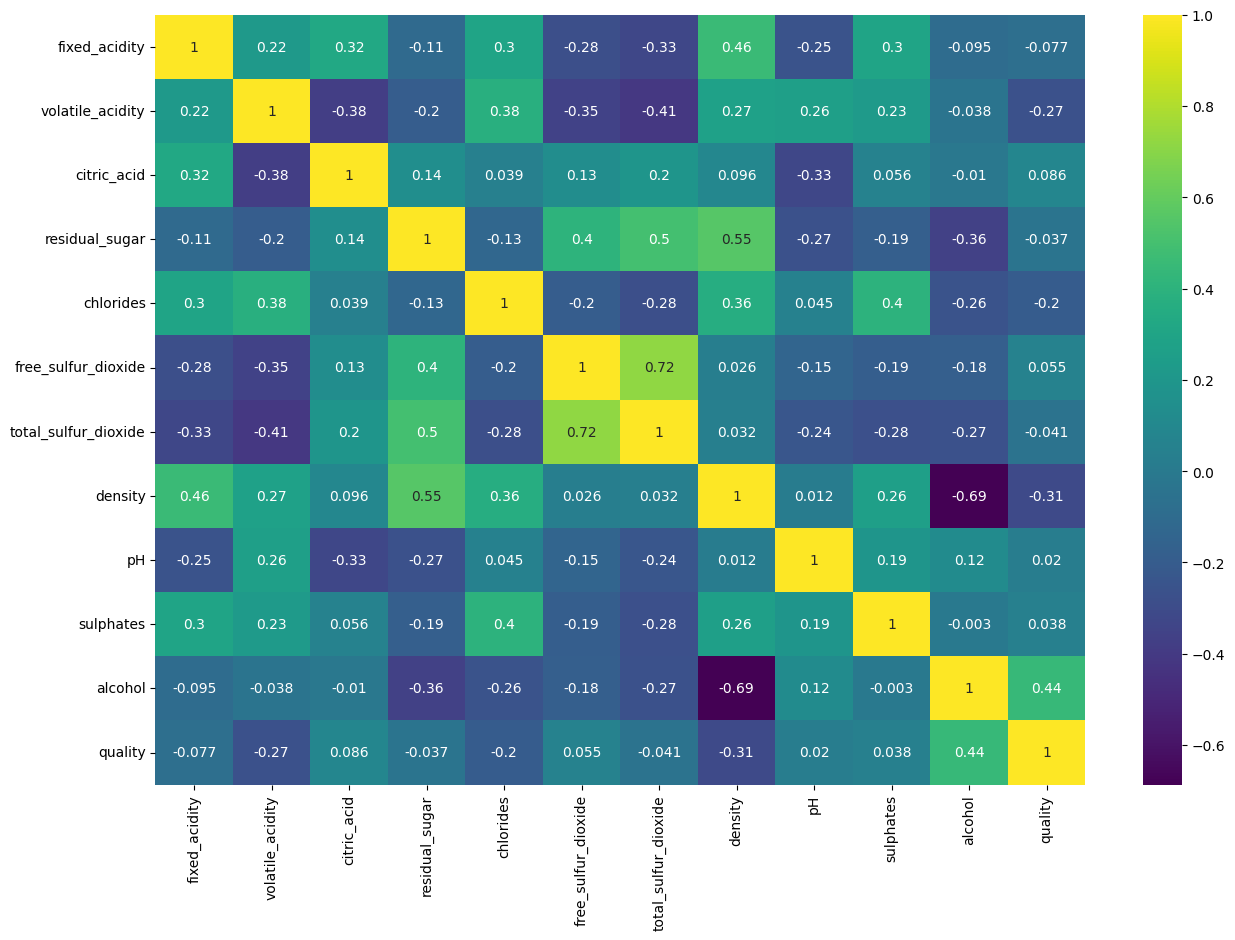

In [21]:
##Preprocessing

#Correlation of all features with the target
corr_mat = df.corr()[dep_var]
target_corr = np.abs(df.corrwith(df[dep_var]))
print(target_corr.sort_values(ascending=False))

#Correlation of features with each other
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()


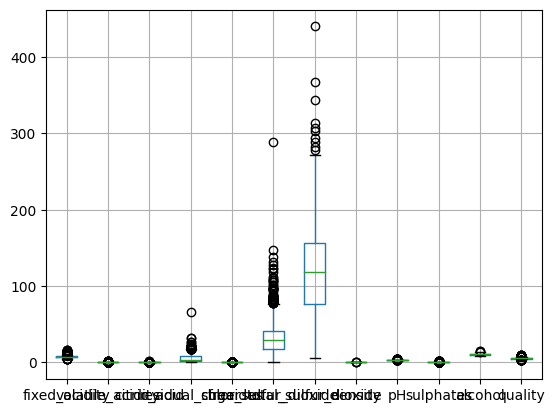

In [22]:
#Boxplot to see the range of feature values
df.boxplot()
plt.show()

In [23]:
#Drop features with low correlation with the target
df.drop(['pH', 'residual_sugar', 'sulphates', 'total_sulfur_dioxide'], axis=1, inplace=True)
cont_names.remove('pH')
cont_names.remove('residual_sugar')
cont_names.remove('sulphates')
cont_names.remove('total_sulfur_dioxide')

In [24]:
#Drop features with too much correlation between them

corr_matrix = df.corr()
threshold = 0.9

# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()


for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrame and the features list
df.drop(columns=to_drop, inplace=True)
cont_names = [col for col in cont_names if col not in to_drop]

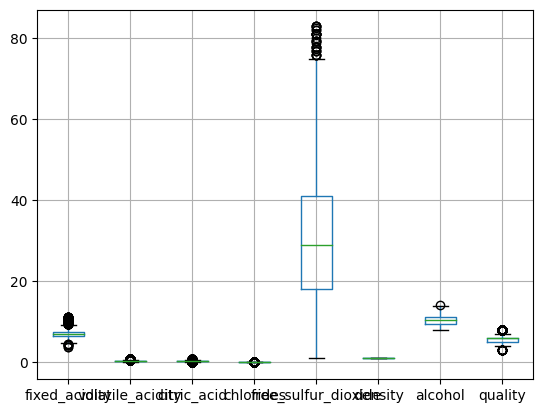

In [25]:
#Remove outliers
df_c = df.loc[(stats.zscore(df) < 3).all(axis=1)]
df_c.boxplot()
plt.show()

In [26]:
# Split indices for training, validation, and test sets
df_c = df_c.reset_index(drop=True)
train_val_split = RandomSplitter(valid_pct=0.3)(range_of(df_c))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

#Normalize
scaler = StandardScaler()
for feat in cont_names:
    df_c.loc[train_idx,feat] = scaler.fit_transform(df_c.loc[train_idx,[feat]])
    df_c.loc[val_idx,feat] = scaler.transform(df_c.loc[val_idx,[feat]])
    df_c.loc[test_idx,feat] = scaler.transform(df_c.loc[test_idx,[feat]])


# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)


# Create DataLoaders for training and validation
dls = to.dataloaders(bs=64, shuffle=True)

test_to = TabularPandas(
    df_c.iloc[test_idx],  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=64, shuffle=False)

dls.to(device)
test_dl.to(device)

In [27]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM']
names_layer=['1 layer', '2 layers', '5 layers', '11 layers']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['AdjR2Sq']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [12]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, layers=layer, n_out=1, metrics=utilsTFG.AdjustedR2Score, loss_func=MSELossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 1              
Linear                                    65         True      
____________________________________________________________________________

Total params: 655
Total trainable params: 655
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fe7a517f380>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  -

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 1              
Linear                                    65         True      
____________________________________________________________________________

Total params: 4,879
Total train

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     64 x 256            
Linear                                    32768      T

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 32             
Linear                                    224        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       T

## Gradient Descent

In [13]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, n_out=1, loss_func = MSELossFlat(), metrics=utilsTFG.AdjustedR2Score, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [14]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")


Mismos parámetros en capa 1.
Mismos parámetros en capa 2.
Mismos parámetros en capa 5.
Mismos parámetros en capa 11.


### Nesterov

Better model found at epoch 0 with valid_loss value: 26.315406799316406.
Better model found at epoch 1 with valid_loss value: 7.320061683654785.
Better model found at epoch 2 with valid_loss value: 0.7770933508872986.
Better model found at epoch 3 with valid_loss value: 0.5931304097175598.
Better model found at epoch 5 with valid_loss value: 0.5720270872116089.
Better model found at epoch 7 with valid_loss value: 0.551143229007721.
Better model found at epoch 8 with valid_loss value: 0.5316829681396484.
Better model found at epoch 10 with valid_loss value: 0.528936505317688.
Better model found at epoch 13 with valid_loss value: 0.5071218013763428.


Better model found at epoch 0 with valid_loss value: 26.250988006591797.
Better model found at epoch 1 with valid_loss value: 4.739952564239502.
Better model found at epoch 2 with valid_loss value: 0.7404998540878296.
Better model found at epoch 3 with valid_loss value: 0.7262219786643982.
Better model found at epoch 4 with valid_loss value: 0.6804253458976746.
Better model found at epoch 5 with valid_loss value: 0.6082110404968262.
Better model found at epoch 8 with valid_loss value: 0.5867419838905334.
Better model found at epoch 9 with valid_loss value: 0.5591533184051514.
Better model found at epoch 10 with valid_loss value: 0.536430299282074.
Better model found at epoch 14 with valid_loss value: 0.5269874334335327.
Better model found at epoch 18 with valid_loss value: 0.5151581168174744.


Better model found at epoch 0 with valid_loss value: 28.366968154907227.
Better model found at epoch 1 with valid_loss value: 10.102803230285645.
Better model found at epoch 2 with valid_loss value: 1.473796010017395.
Better model found at epoch 3 with valid_loss value: 0.7650882005691528.
Better model found at epoch 4 with valid_loss value: 0.6973119974136353.
Better model found at epoch 5 with valid_loss value: 0.6079103946685791.
Better model found at epoch 7 with valid_loss value: 0.532559871673584.
Better model found at epoch 8 with valid_loss value: 0.5068650245666504.
Better model found at epoch 9 with valid_loss value: 0.5057644248008728.
Better model found at epoch 11 with valid_loss value: 0.47668591141700745.
Better model found at epoch 12 with valid_loss value: 0.4529009461402893.
Better model found at epoch 13 with valid_loss value: 0.4323255121707916.


Better model found at epoch 0 with valid_loss value: 29.033628463745117.
Better model found at epoch 1 with valid_loss value: 11.527434349060059.
Better model found at epoch 2 with valid_loss value: 1.6848151683807373.
Better model found at epoch 3 with valid_loss value: 0.9014880657196045.
Better model found at epoch 4 with valid_loss value: 0.719445526599884.
Better model found at epoch 5 with valid_loss value: 0.6132315993309021.
Better model found at epoch 6 with valid_loss value: 0.5089391469955444.
Better model found at epoch 11 with valid_loss value: 0.4670017957687378.
Better model found at epoch 12 with valid_loss value: 0.4469446539878845.
Better model found at epoch 15 with valid_loss value: 0.43162664771080017.
Better model found at epoch 19 with valid_loss value: 0.4263489842414856.


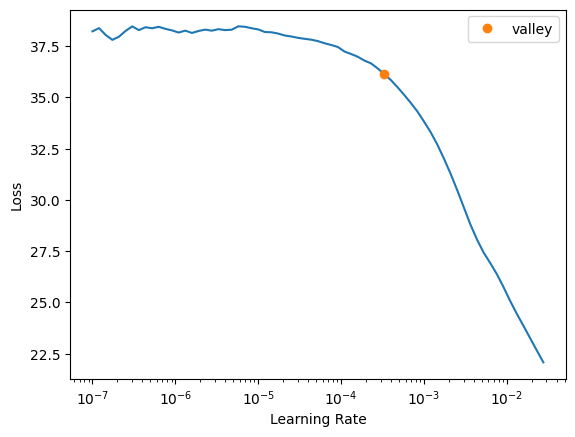

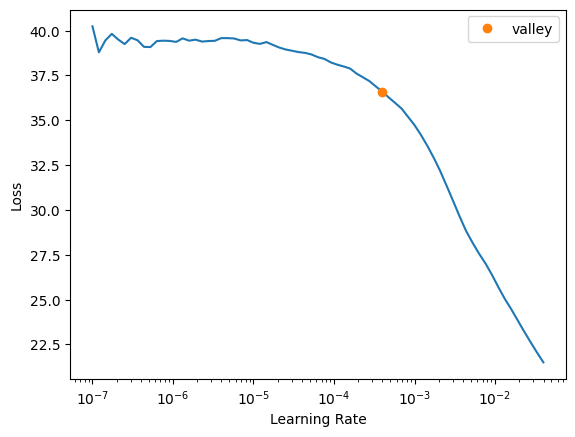

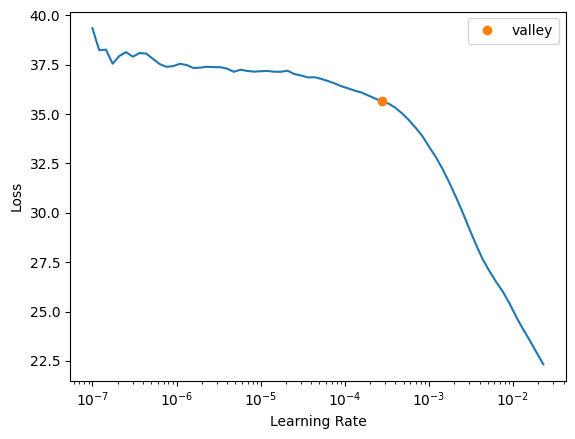

In [15]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



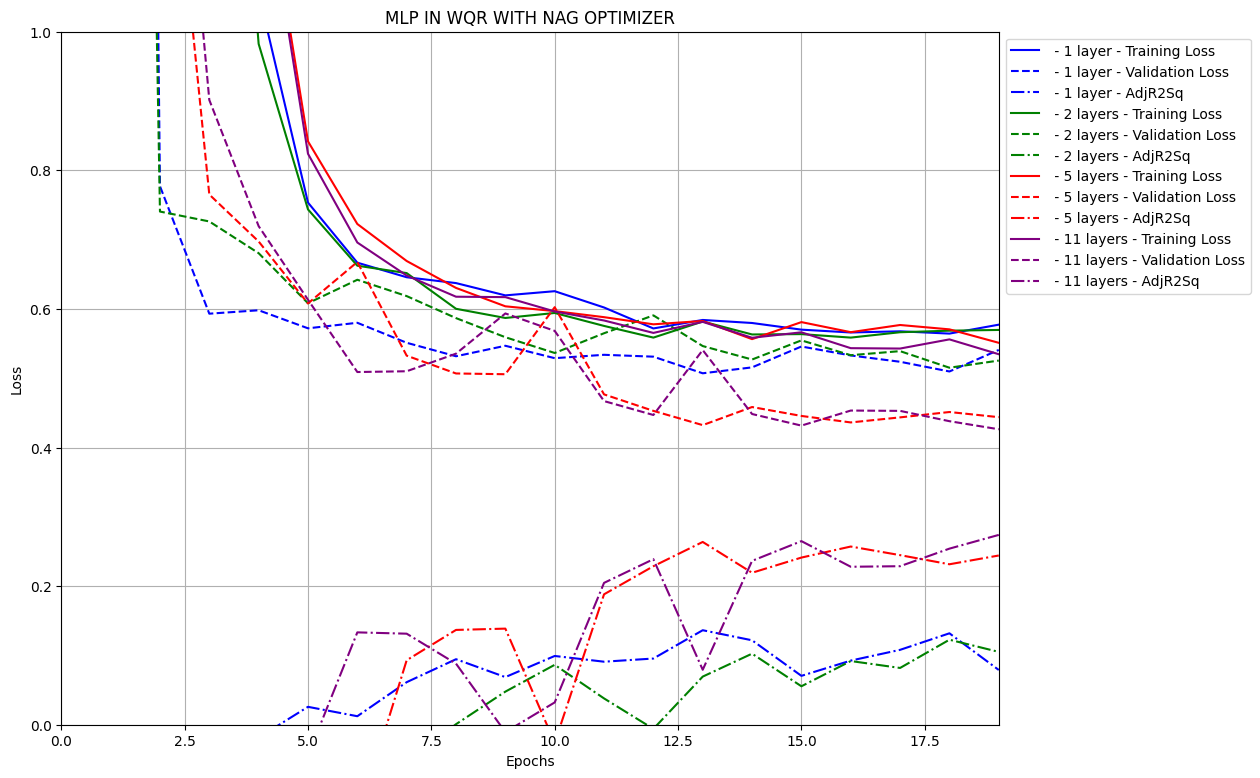

In [16]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title=f'MLP IN {plot_dataset} WITH NAG OPTIMIZER', names=names_layer, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 4.041313171386719.
Better model found at epoch 1 with valid_loss value: 0.7812607288360596.
Better model found at epoch 2 with valid_loss value: 0.5405405759811401.
Better model found at epoch 16 with valid_loss value: 0.4995726943016052.
Better model found at epoch 17 with valid_loss value: 0.456277072429657.


Better model found at epoch 0 with valid_loss value: 8.44970417022705.
Better model found at epoch 1 with valid_loss value: 0.8928499817848206.
Better model found at epoch 2 with valid_loss value: 0.6515182852745056.
Better model found at epoch 3 with valid_loss value: 0.5992085337638855.
Better model found at epoch 4 with valid_loss value: 0.5460429191589355.
Better model found at epoch 5 with valid_loss value: 0.506953775882721.
Better model found at epoch 8 with valid_loss value: 0.48804742097854614.
Better model found at epoch 18 with valid_loss value: 0.48421862721443176.


Better model found at epoch 0 with valid_loss value: 9.07648754119873.
Better model found at epoch 1 with valid_loss value: 0.7997109889984131.
Better model found at epoch 2 with valid_loss value: 0.5408205389976501.
Better model found at epoch 3 with valid_loss value: 0.47800570726394653.


Better model found at epoch 0 with valid_loss value: 2.566970109939575.
Better model found at epoch 1 with valid_loss value: 0.6617521643638611.
Better model found at epoch 3 with valid_loss value: 0.5546549558639526.
Better model found at epoch 5 with valid_loss value: 0.5121846199035645.
Better model found at epoch 10 with valid_loss value: 0.4803938567638397.


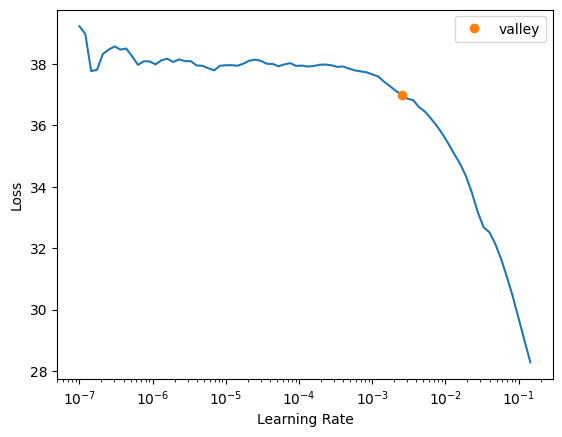

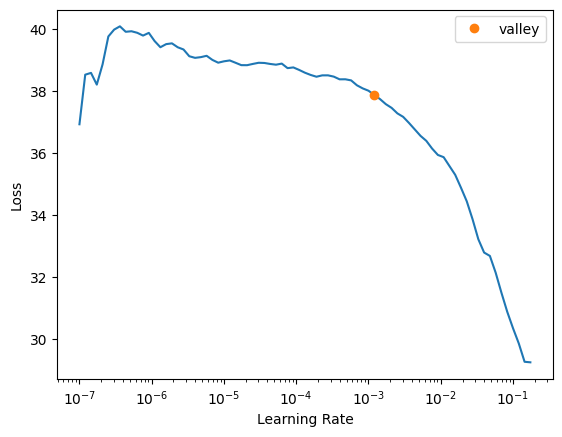

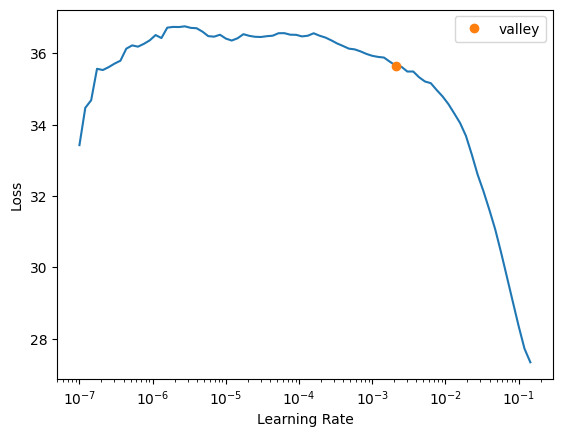

In [17]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


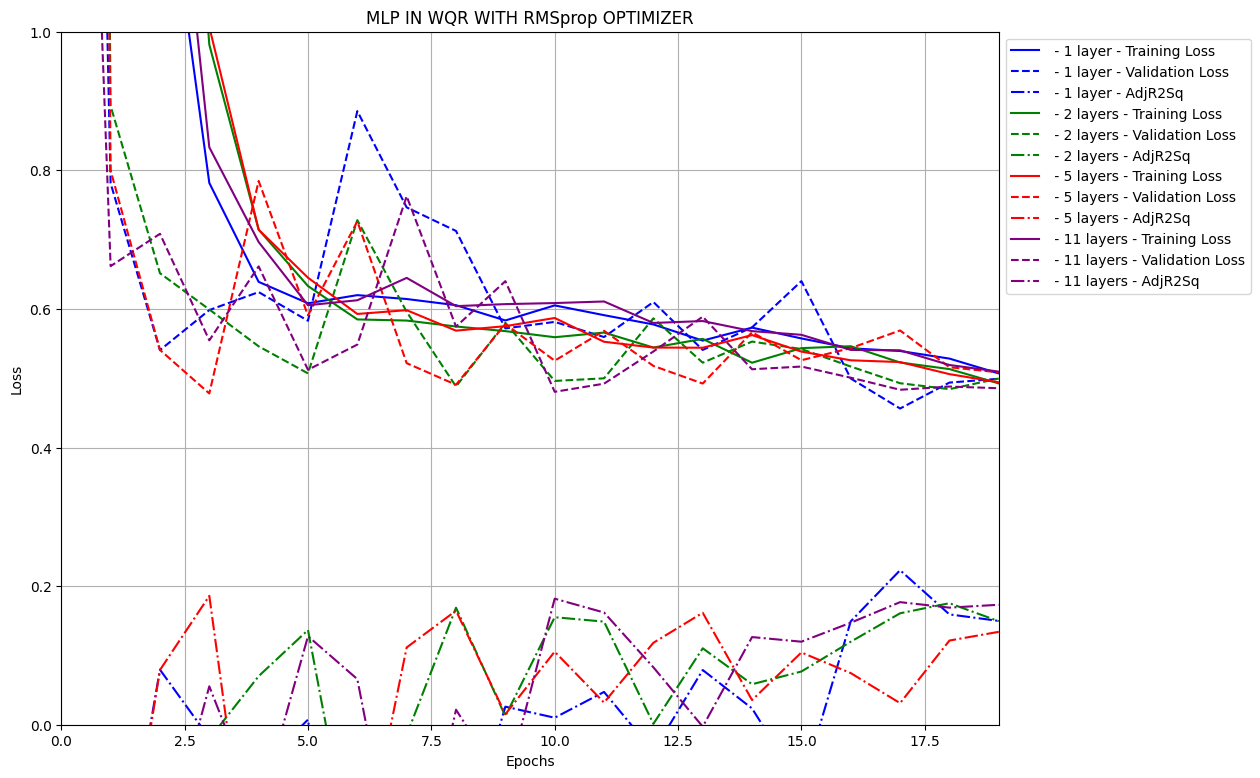

In [18]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title=f'MLP IN {plot_dataset} WITH RMSprop OPTIMIZER', names=names_layer, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 31.412450790405273.
Better model found at epoch 1 with valid_loss value: 3.0624473094940186.
Better model found at epoch 2 with valid_loss value: 0.8725051879882812.
Better model found at epoch 3 with valid_loss value: 0.7159621119499207.
Better model found at epoch 4 with valid_loss value: 0.5686376094818115.
Better model found at epoch 6 with valid_loss value: 0.5300161838531494.
Better model found at epoch 8 with valid_loss value: 0.4346688985824585.


Better model found at epoch 0 with valid_loss value: 31.11026954650879.
Better model found at epoch 1 with valid_loss value: 5.97079610824585.
Better model found at epoch 2 with valid_loss value: 0.7404305934906006.
Better model found at epoch 4 with valid_loss value: 0.49619317054748535.
Better model found at epoch 9 with valid_loss value: 0.46726351976394653.
Better model found at epoch 18 with valid_loss value: 0.45928075909614563.


Better model found at epoch 0 with valid_loss value: 34.12251281738281.
Better model found at epoch 1 with valid_loss value: 26.857486724853516.
Better model found at epoch 2 with valid_loss value: 4.863017559051514.
Better model found at epoch 3 with valid_loss value: 0.8024630546569824.
Better model found at epoch 5 with valid_loss value: 0.6281697154045105.
Better model found at epoch 7 with valid_loss value: 0.595957338809967.
Better model found at epoch 8 with valid_loss value: 0.46229034662246704.
Better model found at epoch 13 with valid_loss value: 0.42270421981811523.


Better model found at epoch 0 with valid_loss value: 30.625329971313477.
Better model found at epoch 1 with valid_loss value: 24.633481979370117.
Better model found at epoch 2 with valid_loss value: 2.0667827129364014.
Better model found at epoch 3 with valid_loss value: 0.7598618865013123.
Better model found at epoch 4 with valid_loss value: 0.5409063696861267.
Better model found at epoch 5 with valid_loss value: 0.5131754875183105.
Better model found at epoch 8 with valid_loss value: 0.4846351146697998.
Better model found at epoch 10 with valid_loss value: 0.4728756546974182.
Better model found at epoch 15 with valid_loss value: 0.45575061440467834.
Better model found at epoch 16 with valid_loss value: 0.44704270362854004.


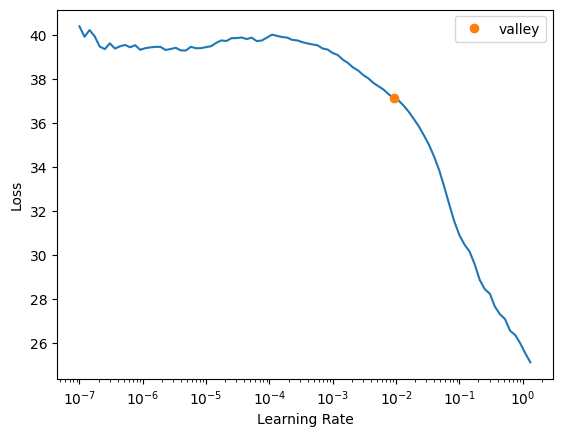

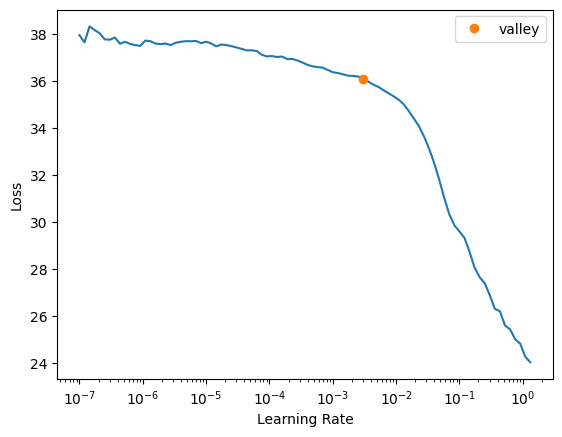

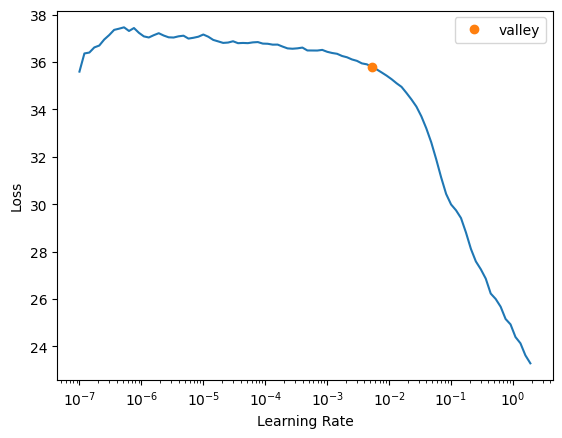

In [19]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


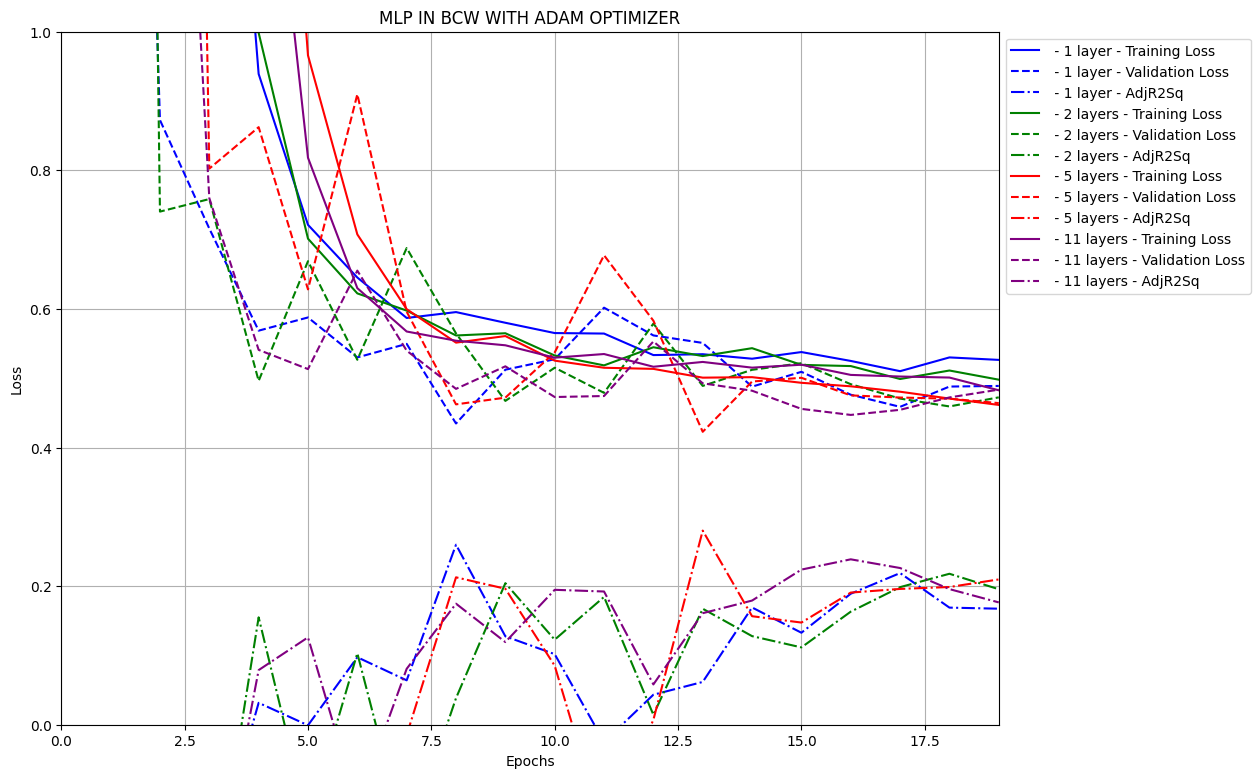

In [20]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='MLP IN BCW WITH ADAM OPTIMIZER', lim=1, names=names_layer, metric=metric)

### Save or Load models

In [21]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)


In [22]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']

### Comparative per layers

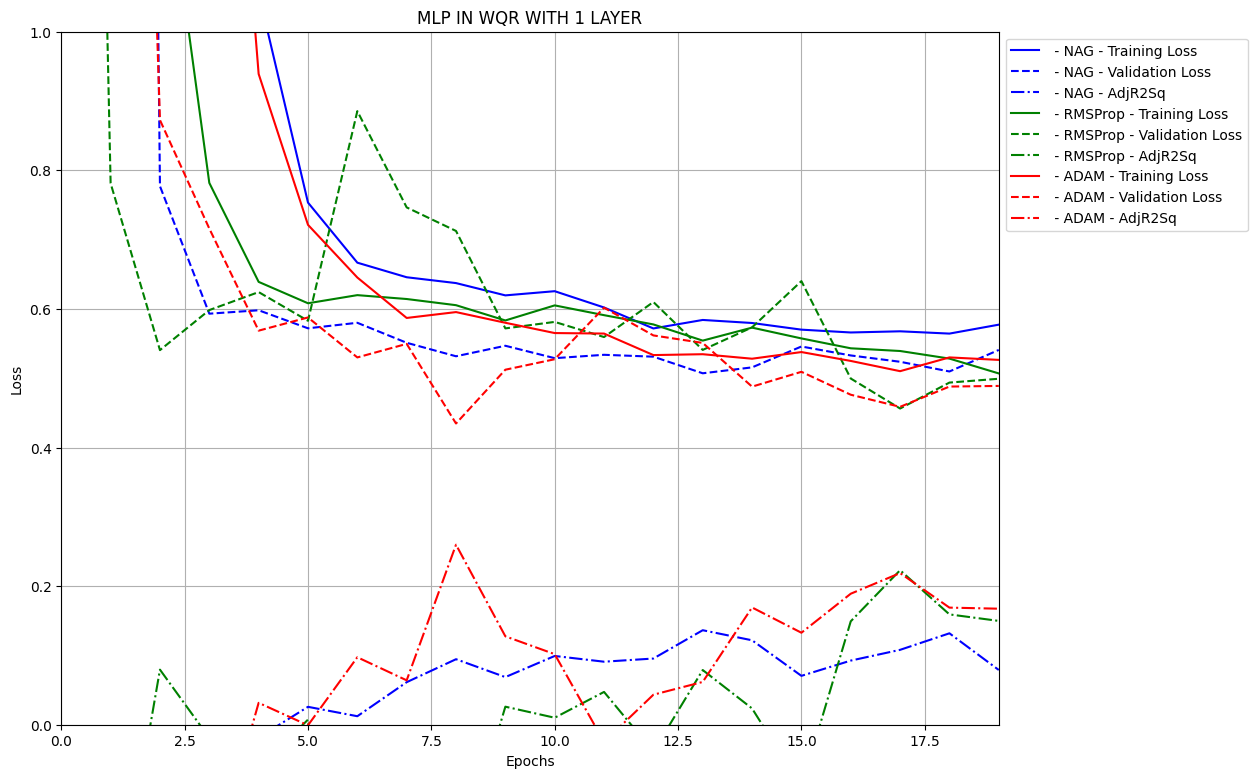

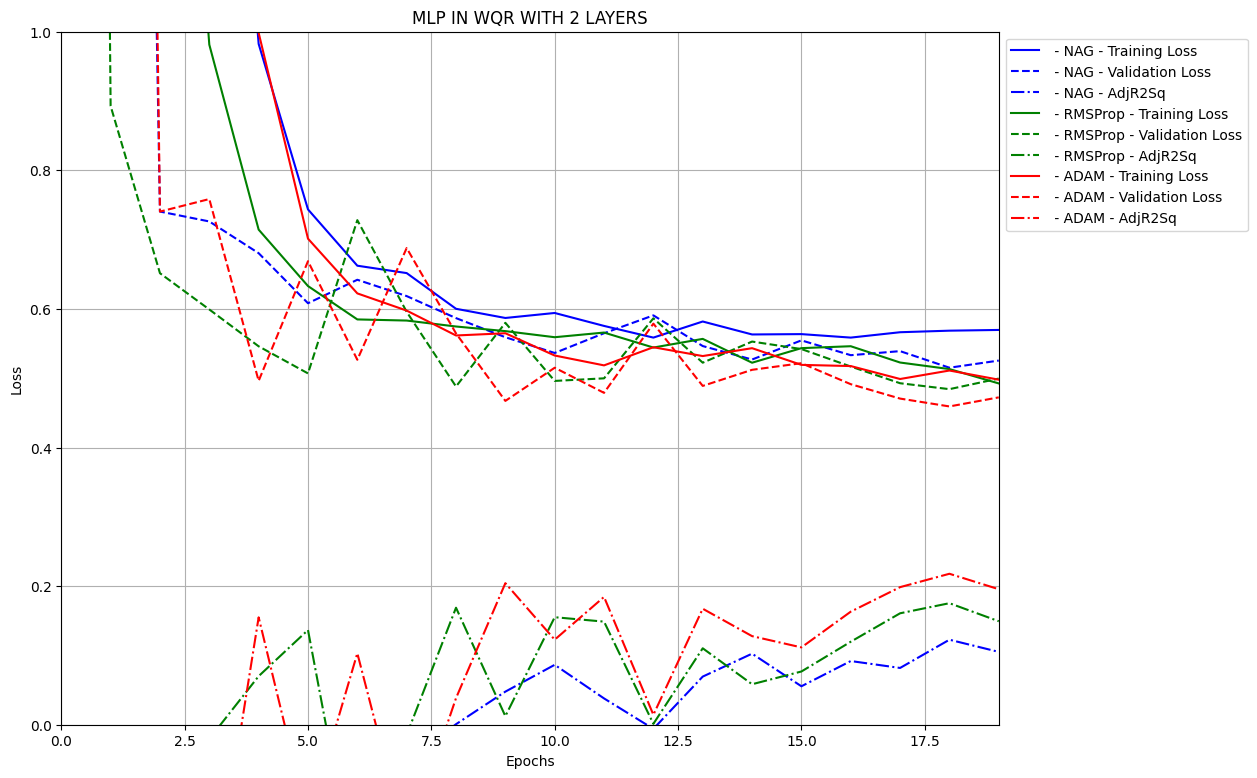

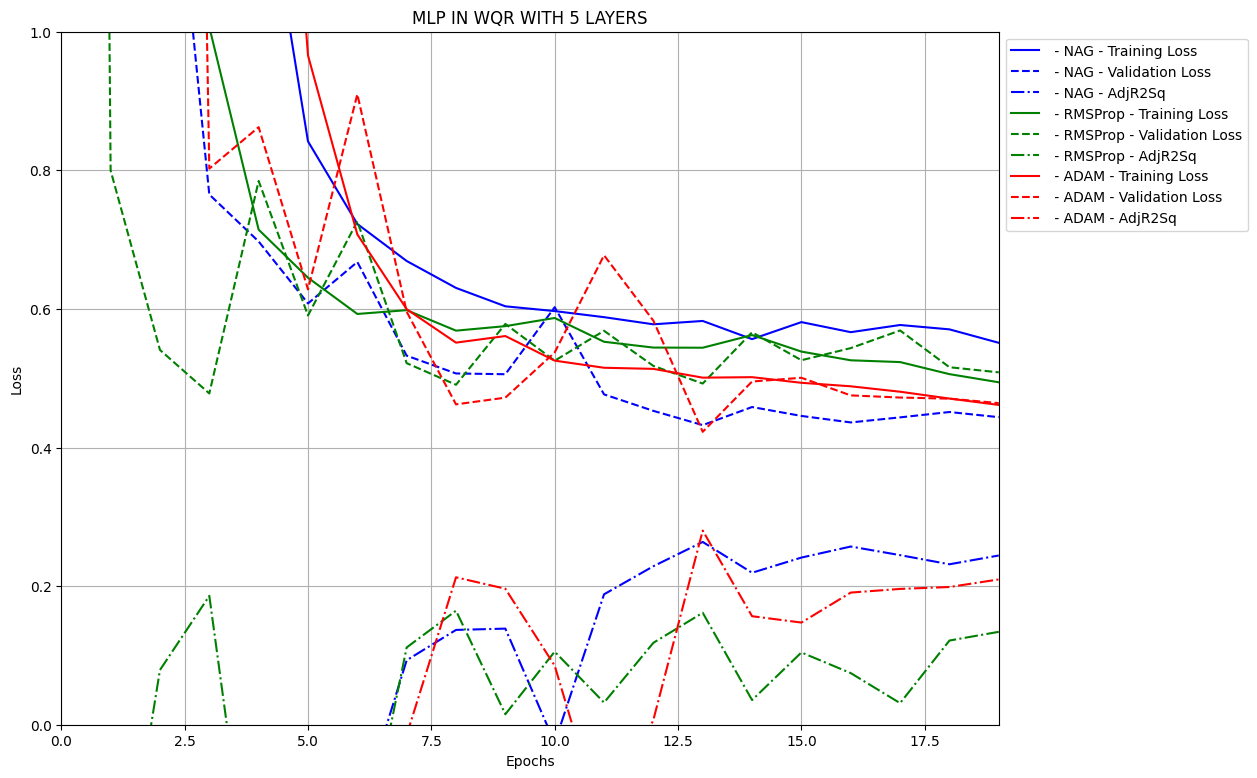

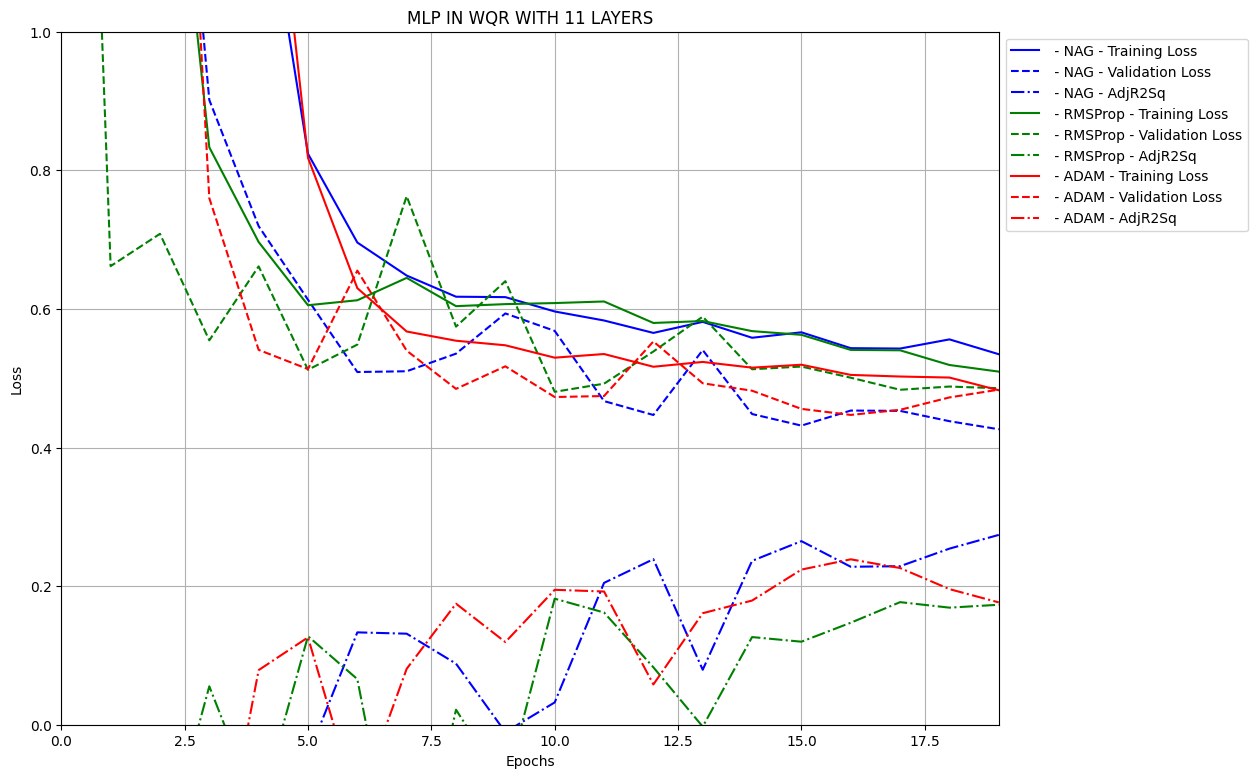

In [23]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11]]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_1_layer, title=f'MLP IN {plot_dataset} WITH 1 LAYER', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, title=f'MLP IN {plot_dataset} WITH 2 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, title=f'MLP IN {plot_dataset} WITH 5 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, title=f'MLP IN {plot_dataset} WITH 11 LAYERS', names=names, metric=metric)

### Generalization

In [24]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()



    #Calculate Adjusted R2 Square

    r2 = utilsTFG.adjusted_r2_score(preds.squeeze(), targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test', task='reg')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Adjusted R2 Square: {r2}")

Optimizer: NAG, Layers: 1, Loss: 0.6177116632461548, Adjusted R2 Square: -1.675132766081766


Optimizer: NAG, Layers: 2, Loss: 0.6004461050033569, Adjusted R2 Square: -1.1514952151320963


Optimizer: NAG, Layers: 5, Loss: 0.5156018137931824, Adjusted R2 Square: -0.6440349487187809


Optimizer: NAG, Layers: 11, Loss: 0.5605015158653259, Adjusted R2 Square: -0.6667741738128861


Optimizer: RMSProp, Layers: 1, Loss: 0.5205315351486206, Adjusted R2 Square: -1.3406198034130576


Optimizer: RMSProp, Layers: 2, Loss: 0.5651134848594666, Adjusted R2 Square: -1.0538678383079159


Optimizer: RMSProp, Layers: 5, Loss: 0.5723552703857422, Adjusted R2 Square: -2.21061547611522


Optimizer: RMSProp, Layers: 11, Loss: 0.5606098771095276, Adjusted R2 Square: -2.561310476303318


Optimizer: ADAM, Layers: 1, Loss: 0.5489017367362976, Adjusted R2 Square: -0.9885749888332938


Optimizer: ADAM, Layers: 2, Loss: 0.545306921005249, Adjusted R2 Square: -1.0825006610834258


Optimizer: ADAM, Layers: 5, Loss: 0.5074037909507751, Adjusted R2 Square: -0.9359825383288207


Optimizer: ADAM, Layers: 11, Loss: 0.5410640239715576, Adjusted R2 Square: -1.1368893123253114


## Metaheuristics

In [28]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  mh_learners[n_layer] = tabular_learner(dls, loss_func=MSELossFlat(), metrics=utilsTFG.AdjustedR2Score ,layers=layer, cbs=[SaveModelCallback()])
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls, task='reg'))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


### Genetic Algorithms

In [26]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [27]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model, task='reg')
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start


In [34]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  fitness_valid['SHADE'][layer] = []
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [43]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [35.09720230102539, 35.09720230102539, 35.05574035644531, 34.8737907409668, 34.8737907409668, 34.810997009277344, 34.71481704711914, 34.71481704711914, 34.71481704711914, 34.71481704711914, 34.71481704711914, 34.71481704711914, 34.668800354003906, 34.668800354003906, 34.668800354003906, 34.59281921386719, 34.59281921386719, 34.59281921386719, 34.59281921386719, 34.59281921386719, 34.59281921386719, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.4448356628418, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.38613510131836, 34.3861

### SHADE-ILS

In [30]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start


eo
deque([1, 0.9805793216085263, 0.0], maxlen=3)
deque([0.9805793216085263, 0.0, -0.026369189464811597], maxlen=3)
235
eo
deque([0.0, -0.026369189464811597, 0.0], maxlen=3)
deque([-0.026369189464811597, 0.0, 0.06200770906653259], maxlen=3)
Reiniciado
457
eo
deque([1, 1, 0.9080301817725925], maxlen=3)
deque([1, 0.9080301817725925, 0.8263303636440221], maxlen=3)
672
eo
deque([0.9080301817725925, 0.8263303636440221, 0.0], maxlen=3)
deque([0.8263303636440221, 0.0, 0.02219604368328425], maxlen=3)
884
eo
deque([0.0, 0.02219604368328425, 0.03081009294183297], maxlen=3)
deque([0.02219604368328425, 0.03081009294183297, -0.005053460383854397], maxlen=3)
Reiniciado
1102
eo
deque([1, 1, 0.9721407127656079], maxlen=3)
deque([1, 0.9721407127656079, 0.7527030071355678], maxlen=3)
1319
eo
deque([0.9721407127656079, 0.7527030071355678, 0.0], maxlen=3)
deque([0.7527030071355678, 0.0, 0.022052334979512776], maxlen=3)
1527
eo
deque([0.0, 0.022052334979512776, 0.0], maxlen=3)
deque([0.022052334979512776, 0

In [35]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [42]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [35.09720230102539, 0.6816114783287048, 0.6816114783287048, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632, 0.6562053561210632]
Validation error of SHADE-ILS for 1 layers: [103.50697326660156, 1044.325927734375, 1044.325927734375, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938, 1023.3783569335938]
Difference: [  68.40977097 1043.644

### SHADE-GD

eo
deque([1, 1, 0.008154646894453043], maxlen=3)
deque([1, 1, 0.008154646894453043], maxlen=3)
eo
deque([1, 0.008154646894453043, 0.0024703320170940883], maxlen=3)
deque([1, 0.008154646894453043, 0.0024703320170940883], maxlen=3)
eo
deque([0.008154646894453043, 0.0024703320170940883, 0.0023080427435015305], maxlen=3)
deque([0.008154646894453043, 0.0024703320170940883, 0.0023080427435015305], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5943253523902599], maxlen=3)
deque([1, 1, 0.5943253523902599], maxlen=3)
eo
deque([1, 0.5943253523902599, 0.81509942498498], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.019957184791565.
deque([0.5943253523902599, 0.81509942498498, 0.5074227839895177], maxlen=3)
eo
deque([0.81509942498498, 0.5074227839895177, 0.2427995261202015], maxlen=3)
deque([0.81509942498498, 0.5074227839895177, 0.2427995261202015], maxlen=3)
eo
deque([0.5074227839895177, 0.2427995261202015, 0.017795640699797846], maxlen=3)
deque([0.5074227839895177, 0.2427995261202015, 0.017795640699797846], maxlen=3)
eo
deque([0.2427995261202015, 0.017795640699797846, 0.11737023415513027], maxlen=3)
deque([0.2427995261202015, 0.017795640699797846, 0.11737023415513027], maxlen=3)
eo
deque([0.017795640699797846, 0.11737023415513027, 0.0], maxlen=3)
deque([0.017795640699797846, 0.11737023415513027, 0.0], maxlen=3)
eo
deque([0.11737023415513027, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5023606419563293.
deque([0.0, 0.0, 0.22339215892413788], maxlen=3)
eo
deque([0.0, 0.22339215892413788, 0.09254665508711074], maxlen=3)
deque([0.0, 0.22339215892413788, 0.09254665508711074], maxlen=3)
eo
deque([0.22339215892413788, 0.09254665508711074, 0.003699313611571694], maxlen=3)
deque([0.22339215892413788, 0.09254665508711074, 0.003699313611571694], maxlen=3)
eo
deque([0.09254665508711074, 0.003699313611571694, 0.0], maxlen=3)
deque([0.09254665508711074, 0.003699313611571694, 0.0], maxlen=3)
eo
deque([0.003699313611571694, 0.0, 0.0406492883101523], maxlen=3)
deque([0.003699313611571694, 0.0, 0.0406492883101523], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8985457264838911], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6115866899490356.
deque([1, 0.8985457264838911, 0.6051486422273604], maxlen=3)
eo
deque([0.8985457264838911, 0.6051486422273604, 0.11090935778121913], maxlen=3)
deque([0.8985457264838911, 0.6051486422273604, 0.11090935778121913], maxlen=3)
eo
deque([0.6051486422273604, 0.11090935778121913, 0.05755108968449326], maxlen=3)
deque([0.6051486422273604, 0.11090935778121913, 0.05755108968449326], maxlen=3)
eo
deque([0.11090935778121913, 0.05755108968449326, 0.0], maxlen=3)
deque([0.11090935778121913, 0.05755108968449326, 0.0], maxlen=3)
eo
deque([0.05755108968449326, 0.0, 0.0], maxlen=3)
deque([0.05755108968449326, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.567415714263916.
deque([0.0, 0.0, -0.1281150042469111], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8183312211914813], maxlen=3)
deque([1, 1, 0.8183312211914813], maxlen=3)
eo
deque([1, 1, 0.022649695747092618], maxlen=3)
deque([1, 1, 0.022649695747092618], maxlen=3)
eo
deque([1, 0.022649695747092618, 0.004949632381142971], maxlen=3)
deque([1, 0.022649695747092618, 0.004949632381142971], maxlen=3)
eo
deque([0.022649695747092618, 0.004949632381142971, 0.007753018425604645], maxlen=3)
deque([0.022649695747092618, 0.004949632381142971, 0.007753018425604645], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7978276684207972], maxlen=3)
deque([1, 1, 0.7978276684207972], maxlen=3)
eo
deque([1, 0.7978276684207972, 0.6905615095369786], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8378788232803345.
deque([0.7978276684207972, 0.6905615095369786, 0.6752225090615752], maxlen=3)
eo
deque([0.6905615095369786, 0.6752225090615752, 0.2669824915795186], maxlen=3)
deque([0.6905615095369786, 0.6752225090615752, 0.2669824915795186], maxlen=3)
eo
deque([0.6752225090615752, 0.2669824915795186, 0.06643800874738712], maxlen=3)
deque([0.6752225090615752, 0.2669824915795186, 0.06643800874738712], maxlen=3)
eo
deque([0.2669824915795186, 0.06643800874738712, 0.11642058868832841], maxlen=3)
deque([0.2669824915795186, 0.06643800874738712, 0.11642058868832841], maxlen=3)
eo
deque([0.06643800874738712, 0.11642058868832841, 0.0], maxlen=3)
deque([0.06643800874738712, 0.11642058868832841, 0.0], maxlen=3)
eo
deque([0.11642058868832841, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6689286828041077.
deque([0.0, 0.0, 0.06527733410111292], maxlen=3)
eo
deque([0.0, 0.06527733410111292, 0.015294518773196698], maxlen=3)
deque([0.0, 0.06527733410111292, 0.015294518773196698], maxlen=3)
eo
deque([0.06527733410111292, 0.015294518773196698, 0.0], maxlen=3)
deque([0.06527733410111292, 0.015294518773196698, 0.0], maxlen=3)
eo
deque([0.015294518773196698, 0.0, 0.0021426939131681155], maxlen=3)
deque([0.015294518773196698, 0.0, 0.0021426939131681155], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.883333540970869], maxlen=3)
deque([1, 1, 0.883333540970869], maxlen=3)
eo
deque([1, 0.883333540970869, 0.22795983263488906], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8620708584785461.
deque([0.883333540970869, 0.22795983263488906, 0.44826974931706665], maxlen=3)
eo
deque([0.22795983263488906, 0.44826974931706665, 0.0686693813274722], maxlen=3)
deque([0.22795983263488906, 0.44826974931706665, 0.0686693813274722], maxlen=3)
eo
deque([0.44826974931706665, 0.0686693813274722, 0.05250376609698312], maxlen=3)
deque([0.44826974931706665, 0.0686693813274722, 0.05250376609698312], maxlen=3)
eo
deque([0.0686693813274722, 0.05250376609698312, 0.0], maxlen=3)
deque([0.0686693813274722, 0.05250376609698312, 0.0], maxlen=3)
eo
deque([0.05250376609698312, 0.0, 0.0], maxlen=3)
deque([0.05250376609698312, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6906011700630188.
deque([0.0, 0.0, 0.13883683104319477], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8960595901738447], maxlen=3)
deque([1, 1, 0.8960595901738447], maxlen=3)
eo
deque([1, 1, 0.012461298279603458], maxlen=3)
deque([1, 1, 0.012461298279603458], maxlen=3)
eo
deque([1, 0.012461298279603458, 0.002555600279255849], maxlen=3)
deque([1, 0.012461298279603458, 0.002555600279255849], maxlen=3)
eo
deque([0.012461298279603458, 0.002555600279255849, 0.0044284054804805215], maxlen=3)
deque([0.012461298279603458, 0.002555600279255849, 0.0044284054804805215], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5352106493995468], maxlen=3)
deque([1, 1, 0.5352106493995468], maxlen=3)
eo
deque([1, 0.5352106493995468, 0.5084234983341658], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7705268859863281.
deque([0.5352106493995468, 0.5084234983341658, 0.851857585437722], maxlen=3)
eo
deque([0.5084234983341658, 0.851857585437722, 0.09457048528063644], maxlen=3)
deque([0.5084234983341658, 0.851857585437722, 0.09457048528063644], maxlen=3)
eo
deque([0.851857585437722, 0.09457048528063644, 0.12827551956021593], maxlen=3)
deque([0.851857585437722, 0.09457048528063644, 0.12827551956021593], maxlen=3)
eo
deque([0.09457048528063644, 0.12827551956021593, 0.09972678705652945], maxlen=3)
deque([0.09457048528063644, 0.12827551956021593, 0.09972678705652945], maxlen=3)
eo
deque([0.12827551956021593, 0.09972678705652945, 0.03457064972845139], maxlen=3)
deque([0.12827551956021593, 0.09972678705652945, 0.03457064972845139], maxlen=3)
eo
deque([0.09972678705652945, 0.03457064972845139, 0.01124364664493264], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5581871271133423.
deque([0.03457064972845139, 0.01124364664493264, 0.16474323386513354], maxlen=3)
eo
deque([0.01124364664493264, 0.16474323386513354, 0.16671839879333994], maxlen=3)
deque([0.01124364664493264, 0.16474323386513354, 0.16671839879333994], maxlen=3)
eo
deque([0.16474323386513354, 0.16671839879333994, 0.0], maxlen=3)
deque([0.16474323386513354, 0.16671839879333994, 0.0], maxlen=3)
eo
deque([0.16671839879333994, 0.0, 0.0], maxlen=3)
deque([0.16671839879333994, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7590518897083159], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6132031679153442.
deque([1, 0.7590518897083159, 0.7279599997120995], maxlen=3)
eo
deque([0.7590518897083159, 0.7279599997120995, 0.12359673709054994], maxlen=3)
deque([0.7590518897083159, 0.7279599997120995, 0.12359673709054994], maxlen=3)
eo
deque([0.7279599997120995, 0.12359673709054994, 0.0], maxlen=3)
deque([0.7279599997120995, 0.12359673709054994, 0.0], maxlen=3)
eo
deque([0.12359673709054994, 0.0, 0.0], maxlen=3)
deque([0.12359673709054994, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.05923683710287714], maxlen=3)
deque([0.0, 0.0, 0.05923683710287714], maxlen=3)
eo
deque([0.0, 0.05923683710287714, 0.030107175059294694], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6262309551239014.
deque([0.05923683710287714, 0.030107175059294694, 0.17469306728632983], maxlen=3)
eo
deque([0.030107175059294694, 0.17469306728632983, 0.018048335459554036], maxlen=3)
deque([0.030107175059294694, 0.17469306728632983, 0.018048335459554036], maxlen=3)
eo
deque([1, 1, 0.03827952582246104], maxlen=3)
deque([1, 1, 0.03827952582246104], maxlen=3)
eo
deque([1, 0.03827952582246104, 0.0], maxlen=3)
deque([1, 0.03827952582246104, 0.0], maxlen=3)
eo
deque([0.03827952582246104, 0.0, 0.0], maxlen=3)
deque([0.03827952582246104, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.416134407084044], maxlen=3)
deque([1, 1, 0.416134407084044], maxlen=3)
eo
deque([1, 0.416134407084044, 0.7647815861845314], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6330583095550537.
deque([0.416134407084044, 0.7647815861845314, 0.7291812028509508], maxlen=3)
eo
deque([0.7647815861845314, 0.7291812028509508, 0.5034917184569159], maxlen=3)
deque([0.7647815861845314, 0.7291812028509508, 0.5034917184569159], maxlen=3)
eo
deque([0.7291812028509508, 0.5034917184569159, 0.14117765156542528], maxlen=3)
deque([0.7291812028509508, 0.5034917184569159, 0.14117765156542528], maxlen=3)
eo
deque([0.5034917184569159, 0.14117765156542528, 0.06425516546463121], maxlen=3)
deque([0.5034917184569159, 0.14117765156542528, 0.06425516546463121], maxlen=3)
eo
deque([0.14117765156542528, 0.06425516546463121, 0.0], maxlen=3)
deque([0.14117765156542528, 0.06425516546463121, 0.0], maxlen=3)
eo
deque([0.06425516546463121, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6216899752616882.
deque([0.0, 0.0, 0.04517277205394582], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7235116144572876], maxlen=3)
deque([1, 1, 0.7235116144572876], maxlen=3)
eo
deque([1, 0.7235116144572876, 0.4761879467381517], maxlen=3)
deque([1, 0.7235116144572876, 0.4761879467381517], maxlen=3)
eo
deque([0.7235116144572876, 0.4761879467381517, 0.20212178169548176], maxlen=3)
deque([0.7235116144572876, 0.4761879467381517, 0.20212178169548176], maxlen=3)
eo
deque([0.4761879467381517, 0.20212178169548176, 0.12645277837994073], maxlen=3)
deque([0.4761879467381517, 0.20212178169548176, 0.12645277837994073], maxlen=3)
eo
deque([0.20212178169548176, 0.12645277837994073, 0.01352540477961728], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6245511174201965.
deque([0.12645277837994073, 0.01352540477961728, 0.4890830674855771], maxlen=3)
eo
deque([0.01352540477961728, 0.4890830674855771, 0.07295951182888918], maxlen=3)
deque([0.01352540477961728, 0.4890830674855771, 0.07295951182888918], maxlen=3)
eo
deque([0.4890830674855771, 0.07295951182888918, 0.011269450296361816], maxlen=3)
deque([0.4890830674855771, 0.07295951182888918, 0.011269450296361816], maxlen=3)
eo
deque([0.07295951182888918, 0.011269450296361816, 0.0], maxlen=3)
deque([0.07295951182888918, 0.011269450296361816, 0.0], maxlen=3)
eo
deque([0.011269450296361816, 0.0, 0.0], maxlen=3)
deque([0.011269450296361816, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.6406588806652258], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5548304915428162.
deque([1, 0.6406588806652258, 0.5757515609793361], maxlen=3)
eo
deque([0.6406588806652258, 0.5757515609793361, 0.09471350595230486], maxlen=3)
deque([0.6406588806652258, 0.5757515609793361, 0.09471350595230486], maxlen=3)


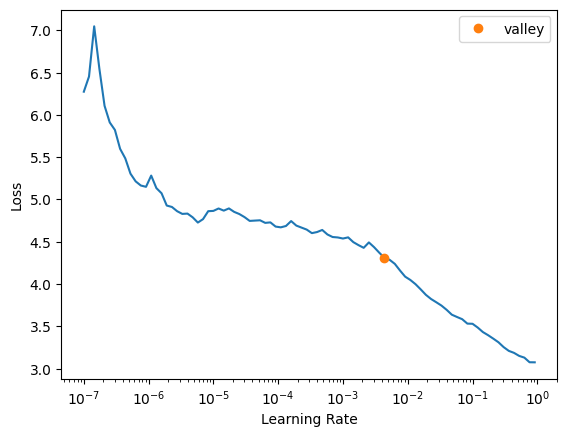

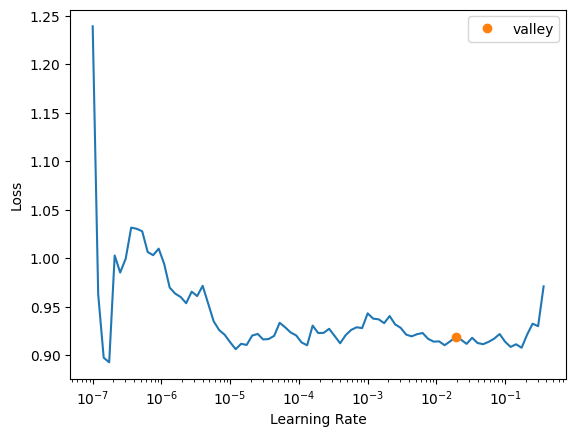

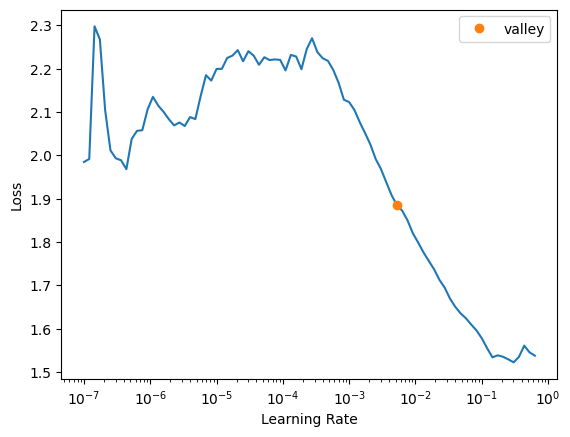

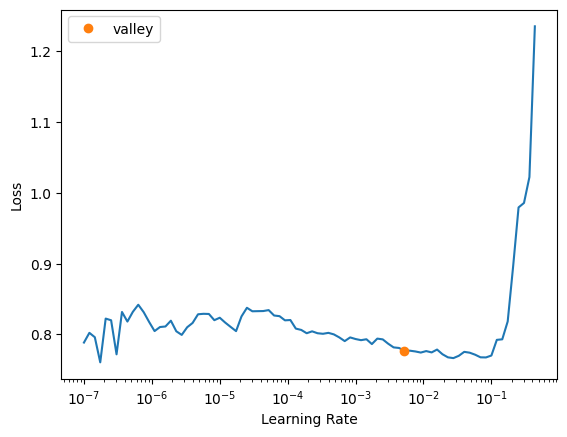

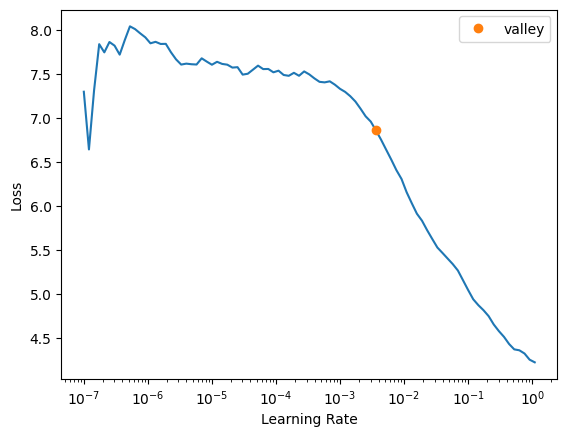

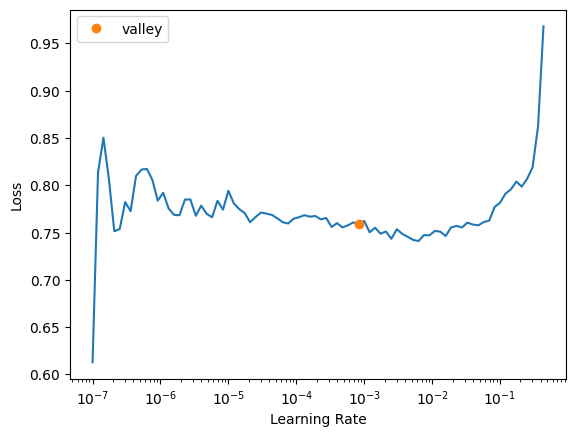

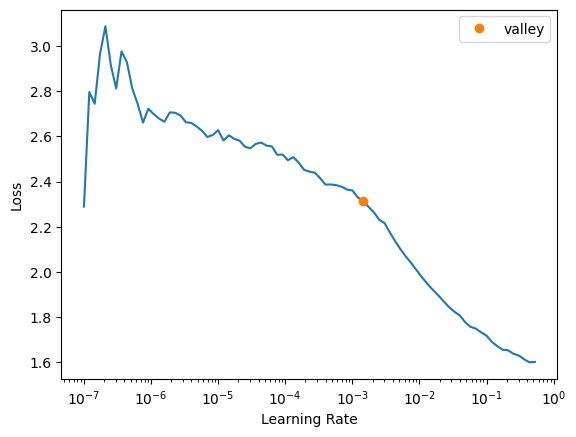

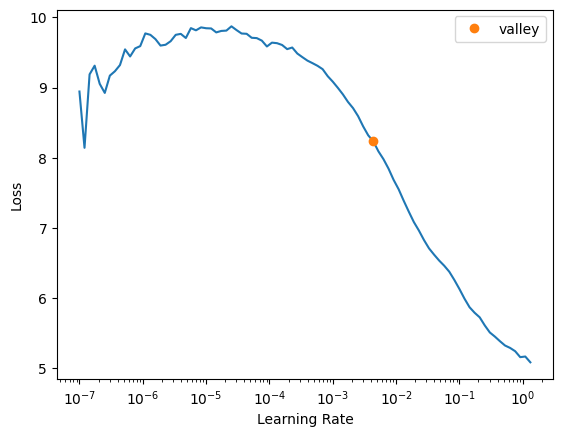

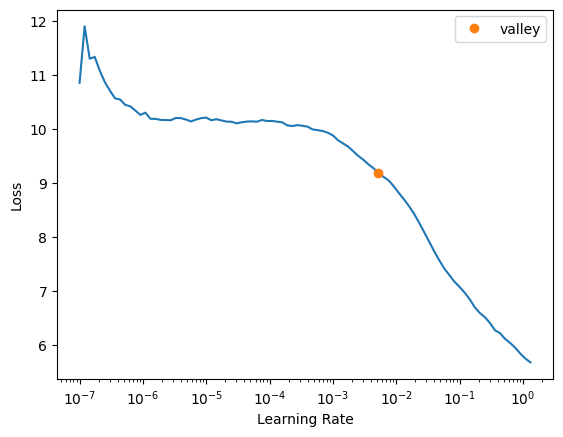

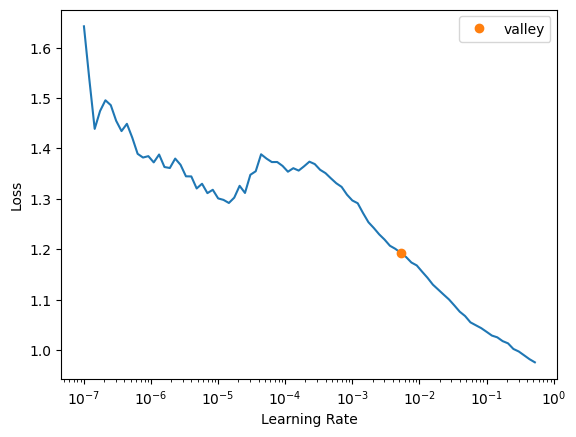

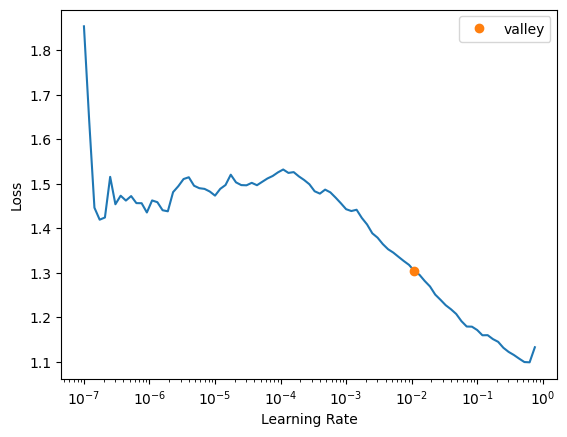

In [33]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start


In [36]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [41]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [35.09720230102539, 34.810997009277344, 34.72500228881836, 34.64485549926758, 15.021056175231934, 1.3680849075317383, 1.0359145402908325, 1.0174797773361206, 0.8980579376220703, 0.8980579376220703, 0.6974388360977173, 0.6328932046890259, 0.6305519342422485, 0.6305519342422485, 0.6049204468727112, 0.6049204468727112, 0.6049204468727112, 0.6049204468727112, 0.6049204468727112, 0.6049204468727112, 0.6049204468727112, 0.6049204468727112]
Validation error of SHADE-GD for 1 layers: [103.50697326660156, 675.8699340820312, 546.0255126953125, 1071.033203125, 359909.34375, 95898.25, 80631.8203125, 122588.7265625, 112474.8359375, 112474.8359375, 34378.4921875, 32402.5625, 36424.609375, 36424.609375, 51378.84765625, 51378.84765625, 51378.84765625, 51378.84765625, 51378.84765625, 51378.84765625, 51378.84765625, 51378.84765625]
Difference: [6.84097710e+01 6.41058937e+02 5.11300510e+02 1.03638835e+03
 3.59894323e+05 9.58968819e+04 8.06307844e+04 1.22587709e+05

### SHADE-ILS-GD

deque([1, 1, 0.9808375882327751], maxlen=3)
eo
deque([1, 0.9808375882327751, 0.0], maxlen=3)
deque([0.9808375882327751, 0.0, 0.009970960166764346], maxlen=3)
deque([0.0, 0.009970960166764346, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7603393339121781], maxlen=3)
deque([1, 0.7603393339121781, 0.5646560998004663], maxlen=3)
deque([0.7603393339121781, 0.5646560998004663, 0.0], maxlen=3)
eo
deque([0.5646560998004663, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.00348663980754071], maxlen=3)
deque([0.0, -0.00348663980754071, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8335076637731805], maxlen=3)
deque([1, 0.8335076637731805, 0.6719729381273095], maxlen=3)
deque([0.8335076637731805, 0.6719729381273095, 0.0], maxlen=3)
eo
deque([0.6719729381273095, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.06339904089915008], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7421681880950928.
deque([0.0, 0.06339904089915008, -0.010959237746782506], maxlen=3)
eo
deque([0.06339904089915008, -0.010959237746782506, 0.027574698341170836], maxlen=3)
deque([-0.010959237746782506, 0.027574698341170836, 0.07527059949424743], maxlen=3)
deque([0.027574698341170836, 0.07527059949424743, 0.0], maxlen=3)
eo
deque([0.07527059949424743, 0.0, 0.0028545489582565073], maxlen=3)
deque([0.0, 0.0028545489582565073, -0.005569031069033623], maxlen=3)
deque([0.0028545489582565073, -0.005569031069033623, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8261368968222637], maxlen=3)
deque([1, 0.8261368968222637, 0.6384637420960645], maxlen=3)
deque([0.8261368968222637, 0.6384637420960645, 0.0], maxlen=3)
eo
deque([0.6384637420960645, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.030615874553811772], maxlen=3)
deque([0.0, 0.030615874553811772, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.961182073810168], maxlen=3)
deque([1, 0.9611820738101

Better model found at epoch 0 with valid_loss value: 0.5603792667388916.
deque([0.961182073810168, 0.647649190133072, -0.22642294158084686], maxlen=3)
eo
deque([0.647649190133072, -0.22642294158084686, 0.18462060183658172], maxlen=3)
deque([-0.22642294158084686, 0.18462060183658172, 0.09395030001529679], maxlen=3)
deque([0.18462060183658172, 0.09395030001529679, 0.0], maxlen=3)
eo
deque([0.09395030001529679, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.014645624711568385], maxlen=3)
deque([0.0, 0.014645624711568385, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.9047879511697592], maxlen=3)
deque([1, 0.9047879511697592, 0.5700181216879759], maxlen=3)
deque([0.9047879511697592, 0.5700181216879759, 0.0], maxlen=3)
eo
deque([0.5700181216879759, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.034831562712197575], maxlen=3)
deque([0.0, 0.034831562712197575, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.9572535376483116], maxlen=3)
deque([1, 0.9572535376483116, 0.6430890407858404], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5841729044914246.
deque([0.9572535376483116, 0.6430890407858404, -0.08969817551652218], maxlen=3)
eo
deque([0.6430890407858404, -0.08969817551652218, 0.23396152395219216], maxlen=3)
deque([-0.08969817551652218, 0.23396152395219216, 0.025906950160138748], maxlen=3)
deque([0.23396152395219216, 0.025906950160138748, 0.0], maxlen=3)
eo
deque([0.025906950160138748, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.011223641645752416], maxlen=3)
deque([0.0, 0.011223641645752416, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.9759414294618002], maxlen=3)
deque([1, 0.9759414294618002, 0.594504083808814], maxlen=3)
deque([0.9759414294618002, 0.594504083808814, 0.0], maxlen=3)
eo
deque([0.594504083808814, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.25365286114801355], maxlen=3)
deque([0.0, 0.25365286114801355, 0.0], maxlen=3)
eo
deque([0.25365286114801355, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.0010231635437148439], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6434635519981384.
deque([0.0, -0.0010231635437148439, -0.30509420400731874], maxlen=3)
Reiniciado
deque([1, 1, 0.9825401141240343], maxlen=3)
eo
deque([1, 0.9825401141240343, 0.0], maxlen=3)
deque([0.9825401141240343, 0.0, -0.0281163742365236], maxlen=3)
deque([0.0, -0.0281163742365236, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7395636020616901], maxlen=3)
deque([1, 0.7395636020616901, 0.6832422484061166], maxlen=3)
deque([0.7395636020616901, 0.6832422484061166, 0.0], maxlen=3)
eo
deque([0.6832422484061166, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.039184412529486685], maxlen=3)
deque([0.0, 0.039184412529486685, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8317411235463492], maxlen=3)
deque([1, 0.8317411235463492, 0.6649183613917106], maxlen=3)
deque([0.8317411235463492, 0.6649183613917106, 0.0], maxlen=3)
eo
deque([0.6649183613917106, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.06529740834470156], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5163421630859375.
deque([0.0, 0.06529740834470156, -0.062474968544257145], maxlen=3)
eo
deque([0.06529740834470156, -0.062474968544257145, 0.11591161658002407], maxlen=3)
deque([-0.062474968544257145, 0.11591161658002407, 0.0714418661620043], maxlen=3)
deque([0.11591161658002407, 0.0714418661620043, 0.0], maxlen=3)
eo
deque([0.0714418661620043, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.014687281685310197], maxlen=3)
deque([0.0, 0.014687281685310197, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8209868137801897], maxlen=3)
deque([1, 0.8209868137801897, 0.6230224191808511], maxlen=3)
deque([0.8209868137801897, 0.6230224191808511, 0.0], maxlen=3)
eo
deque([0.6230224191808511, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.06181136903112557], maxlen=3)
deque([0.0, 0.06181136903112557, 0.0], maxlen=3)
eo
deque([0.06181136903112557, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.01648864213263168], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5444552898406982.
deque([0.0, -0.01648864213263168, -0.04076924859175082], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8270644027710162], maxlen=3)
deque([1, 0.8270644027710162, 0.6991576269938133], maxlen=3)
deque([0.8270644027710162, 0.6991576269938133, 0.0], maxlen=3)
eo
deque([0.6991576269938133, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0389033955114426], maxlen=3)
deque([0.0, 0.0389033955114426, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8898653954991388], maxlen=3)
deque([1, 0.8898653954991388, 0.509522327237725], maxlen=3)
deque([0.8898653954991388, 0.509522327237725, 0.0], maxlen=3)
eo
deque([0.509522327237725, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.055285010637952985], maxlen=3)
deque([0.0, 0.055285010637952985, 0.0], maxlen=3)
eo
deque([0.055285010637952985, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.014010417593278972], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7085446715354919.
deque([0.0, 0.014010417593278972, -0.08769771045576365], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.9116501734275723], maxlen=3)
deque([1, 0.9116501734275723, 0.7053197030960026], maxlen=3)
deque([0.9116501734275723, 0.7053197030960026, 0.0], maxlen=3)
eo
deque([0.7053197030960026, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.022630793552667304], maxlen=3)
deque([0.0, 0.022630793552667304, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7183929492734386], maxlen=3)
deque([1, 0.7183929492734386, 0.7195266929407289], maxlen=3)
deque([0.7183929492734386, 0.7195266929407289, 0.0], maxlen=3)
eo
deque([0.7195266929407289, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.038158524138415625], maxlen=3)
deque([0.0, 0.038158524138415625, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7829306249800138], maxlen=3)
deque([1, 0.7829306249800138, 0.5825663332709442], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.015489101409912.
deque([0.7829306249800138, 0.5825663332709442, -0.172293828778173], maxlen=3)
deque([1, 1, 0.9823048680997428], maxlen=3)
eo
deque([1, 0.9823048680997428, 0.020051309011936573], maxlen=3)
deque([0.9823048680997428, 0.020051309011936573, 0.09895186359843537], maxlen=3)
deque([0.020051309011936573, 0.09895186359843537, 0.0], maxlen=3)
eo
deque([0.09895186359843537, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.04298408504458563], maxlen=3)
deque([0.0, -0.04298408504458563, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.834879422160167], maxlen=3)
deque([1, 0.834879422160167, 0.7521785356613317], maxlen=3)
deque([0.834879422160167, 0.7521785356613317, 0.0], maxlen=3)
eo
deque([0.7521785356613317, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.011413039198979779], maxlen=3)
deque([0.0, 0.011413039198979779, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8051309292582591], maxlen=3)
deque([1, 0.8051309292582591, 0.791288280739024], max

Better model found at epoch 0 with valid_loss value: 0.6514458060264587.
deque([0.8051309292582591, 0.791288280739024, -0.2895806412333451], maxlen=3)
eo
deque([0.791288280739024, -0.2895806412333451, 0.22906405959276369], maxlen=3)
deque([-0.2895806412333451, 0.22906405959276369, 0.004589453354602544], maxlen=3)
deque([0.22906405959276369, 0.004589453354602544, 0.0], maxlen=3)
eo
deque([0.004589453354602544, 0.0, 0.021146617626346936], maxlen=3)
deque([0.0, 0.021146617626346936, -0.0463474870856212], maxlen=3)
deque([0.021146617626346936, -0.0463474870856212, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5496343432083587], maxlen=3)
deque([1, 0.5496343432083587, 0.7515275550479055], maxlen=3)
deque([0.5496343432083587, 0.7515275550479055, 0.0], maxlen=3)
eo
deque([0.7515275550479055, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.021777184892847003], maxlen=3)
deque([0.0, 0.021777184892847003, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7792315292496839], maxlen=3)
deque([1, 0.77923152924968

Better model found at epoch 0 with valid_loss value: 0.7172895669937134.
deque([0.7792315292496839, 0.740122111576504, -0.5260475393714358], maxlen=3)
eo
deque([0.740122111576504, -0.5260475393714358, 0.344712419370703], maxlen=3)
deque([-0.5260475393714358, 0.344712419370703, -0.05468990260903203], maxlen=3)
deque([0.344712419370703, -0.05468990260903203, 0.0], maxlen=3)
eo
deque([-0.05468990260903203, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.05522928294609579], maxlen=3)
deque([0.0, 0.05522928294609579, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.6523094189002877], maxlen=3)
deque([1, 0.6523094189002877, 0.7305762198719057], maxlen=3)
deque([0.6523094189002877, 0.7305762198719057, 0.0], maxlen=3)
eo
deque([0.7305762198719057, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.0324621600341607], maxlen=3)
deque([0.0, -0.0324621600341607, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8268216549498675], maxlen=3)
deque([1, 0.8268216549498675, 0.6905759376291799], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7558797597885132.
deque([0.8268216549498675, 0.6905759376291799, -0.1686859036714755], maxlen=3)
eo
deque([0.6905759376291799, -0.1686859036714755, 0.14433810071768788], maxlen=3)
deque([-0.1686859036714755, 0.14433810071768788, 0.010582679598314665], maxlen=3)
deque([0.14433810071768788, 0.010582679598314665, 0.0], maxlen=3)
eo
deque([0.010582679598314665, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.01440713196914407], maxlen=3)
deque([0.0, 0.01440713196914407, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8320287341491399], maxlen=3)
deque([1, 0.8320287341491399, 0.7031045427779102], maxlen=3)
deque([0.8320287341491399, 0.7031045427779102, 0.0], maxlen=3)
eo
deque([0.7031045427779102, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.010442048215498184], maxlen=3)
deque([0.0, -0.010442048215498184, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8697534312207053], maxlen=3)
deque([1, 0.8697534312207053, 0.7184319733200171], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5561596155166626.
deque([0.8697534312207053, 0.7184319733200171, -0.23476693564423626], maxlen=3)
deque([1, 1, 0.9791332208495763], maxlen=3)
eo
deque([1, 0.9791332208495763, 0.0], maxlen=3)
deque([0.9791332208495763, 0.0, 0.03587961403934141], maxlen=3)
deque([0.0, 0.03587961403934141, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7462579290290702], maxlen=3)
deque([1, 0.7462579290290702, 0.6450562563725865], maxlen=3)
deque([0.7462579290290702, 0.6450562563725865, 0.0], maxlen=3)
eo
deque([0.6450562563725865, 0.0, 0.005813249651239258], maxlen=3)
deque([0.0, 0.005813249651239258, 0.06502588825190105], maxlen=3)
deque([0.005813249651239258, 0.06502588825190105, 0.0], maxlen=3)
eo
deque([0.06502588825190105, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.002229888668008195], maxlen=3)
deque([0.0, -0.002229888668008195, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5030822984141796], maxlen=3)
deque([1, 0.5030822984141796, 0.548221905687474

Better model found at epoch 0 with valid_loss value: 0.6519303917884827.
deque([0.5030822984141796, 0.548221905687474, 0.1334644614773103], maxlen=3)
eo
deque([0.548221905687474, 0.1334644614773103, 0.01614280182468998], maxlen=3)
deque([0.1334644614773103, 0.01614280182468998, 0.1893837970558323], maxlen=3)
deque([0.01614280182468998, 0.1893837970558323, 0.0], maxlen=3)
eo
deque([0.1893837970558323, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.055174418973689056], maxlen=3)
deque([0.0, -0.055174418973689056, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7221323680501819], maxlen=3)
deque([1, 0.7221323680501819, 0.47593093077559967], maxlen=3)
deque([0.7221323680501819, 0.47593093077559967, 0.0], maxlen=3)
eo
deque([0.47593093077559967, 0.0, 0.02215436235954184], maxlen=3)
deque([0.0, 0.02215436235954184, 0.12039121275136365], maxlen=3)
deque([0.02215436235954184, 0.12039121275136365, 0.0], maxlen=3)
eo
deque([0.12039121275136365, 0.0, 0.017239723185568146], maxlen=3)
deque([0.0, 0.01723972

Better model found at epoch 0 with valid_loss value: 0.5593182444572449.
deque([0.017239723185568146, 0.0432853529279142, 0.1938446270538068], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8310095234821173], maxlen=3)
deque([1, 0.8310095234821173, 0.5235610975962202], maxlen=3)
deque([0.8310095234821173, 0.5235610975962202, 0.0], maxlen=3)
eo
deque([0.5235610975962202, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.18258839356216064], maxlen=3)
deque([0.0, 0.18258839356216064, 0.0], maxlen=3)
eo
deque([0.18258839356216064, 0.0, 0.017634053421012773], maxlen=3)
deque([0.0, 0.017634053421012773, -0.0456927896622976], maxlen=3)
deque([0.017634053421012773, -0.0456927896622976, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5743262073547792], maxlen=3)
deque([1, 0.5743262073547792, 0.4585012255349102], maxlen=3)
deque([0.5743262073547792, 0.4585012255349102, 0.0], maxlen=3)
eo
deque([0.4585012255349102, 0.0, 0.008521348736638006], maxlen=3)
deque([0.0, 0.008521348736638006, 0.17550077706178624], maxlen=3)

Better model found at epoch 0 with valid_loss value: 0.8290431499481201.
deque([0.008521348736638006, 0.17550077706178624, 0.12954677539230705], maxlen=3)
eo
deque([0.17550077706178624, 0.12954677539230705, 0.058389805172044985], maxlen=3)
deque([0.12954677539230705, 0.058389805172044985, -0.03428161538589011], maxlen=3)
deque([0.058389805172044985, -0.03428161538589011, 0.0], maxlen=3)
eo
deque([-0.03428161538589011, 0.0, 0.07117909607364716], maxlen=3)
deque([0.0, 0.07117909607364716, -0.04211226381868262], maxlen=3)
deque([0.07117909607364716, -0.04211226381868262, 0.0], maxlen=3)
eo
deque([-0.04211226381868262, 0.0, 0.05180232331567559], maxlen=3)
deque([0.0, 0.05180232331567559, -0.08179753325636833], maxlen=3)
deque([0.05180232331567559, -0.08179753325636833, 0.0], maxlen=3)
eo
deque([-0.08179753325636833, 0.0, 0.07903122408812326], maxlen=3)
deque([0.0, 0.07903122408812326, -0.009569459432777186], maxlen=3)
deque([0.07903122408812326, -0.009569459432777186, 0.0], maxlen=3)
eo
de

Better model found at epoch 0 with valid_loss value: 2.3263626098632812.
deque([0.026210327669262595, -0.06120314982827655, 0.0331842909186114], maxlen=3)
Reiniciado


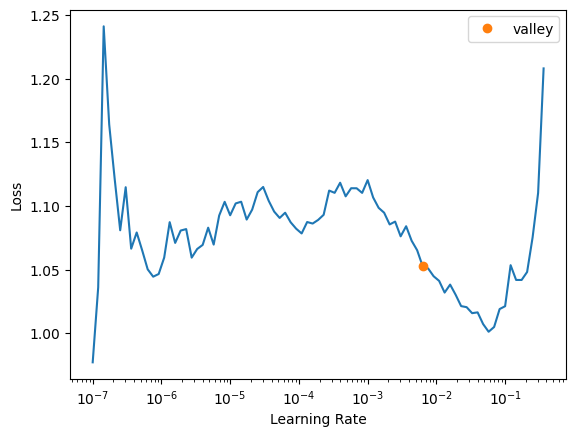

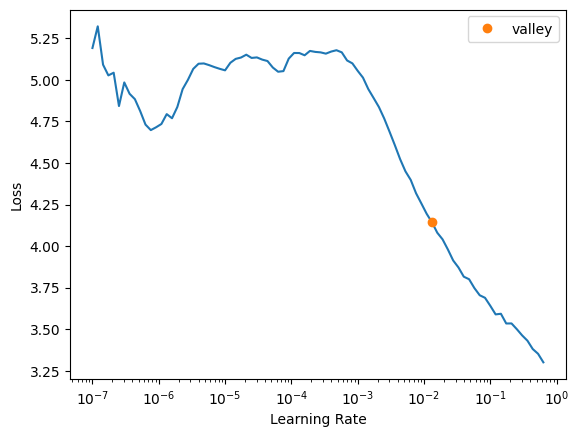

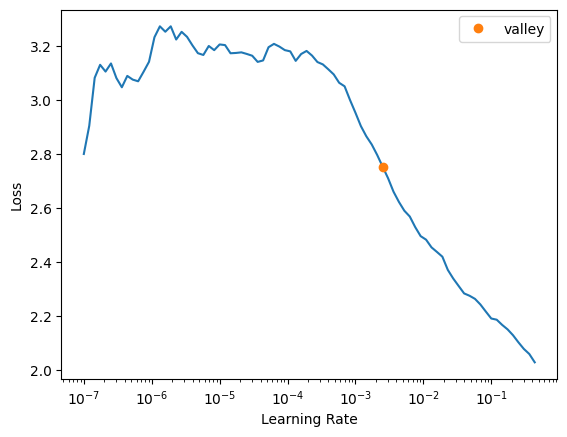

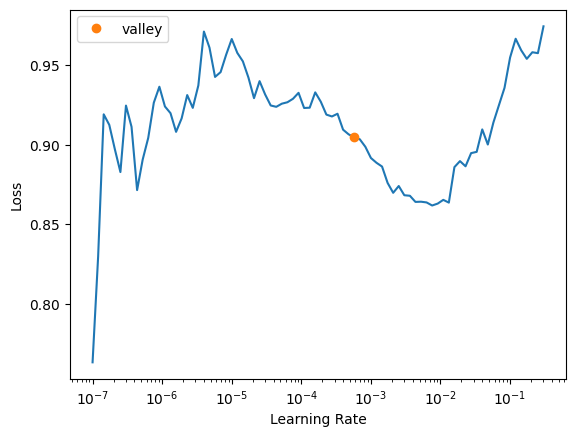

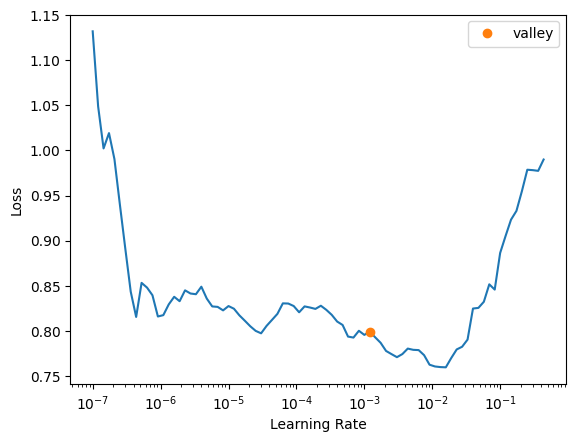

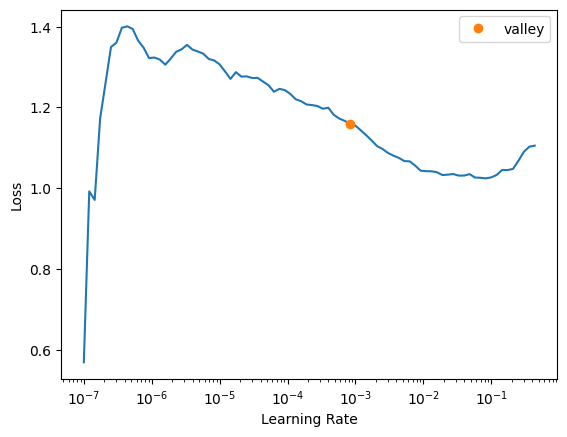

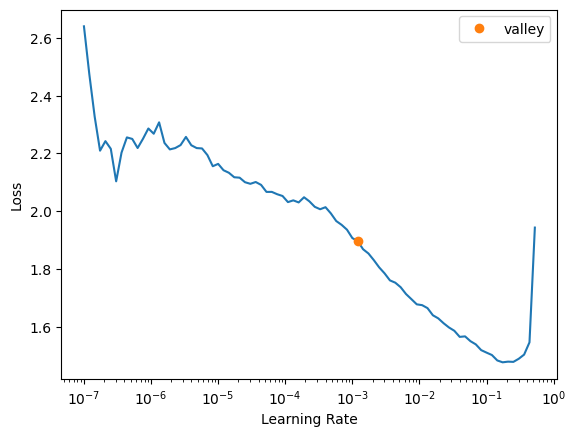

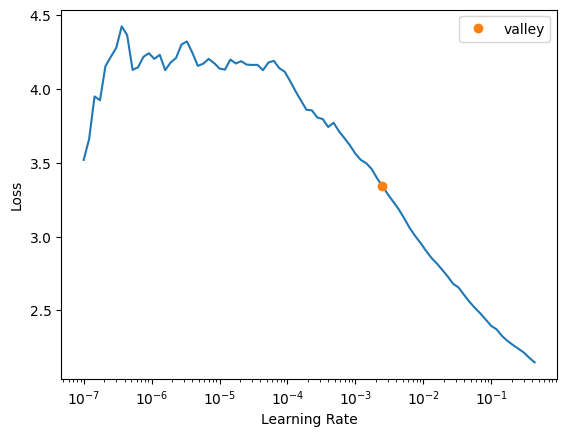

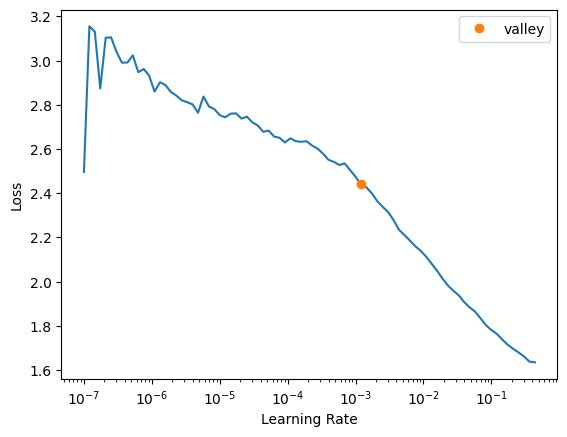

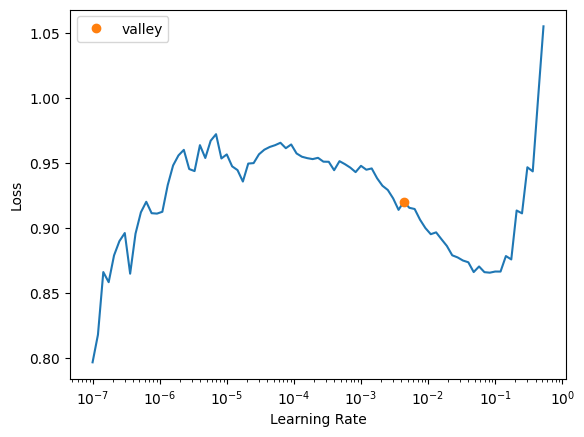

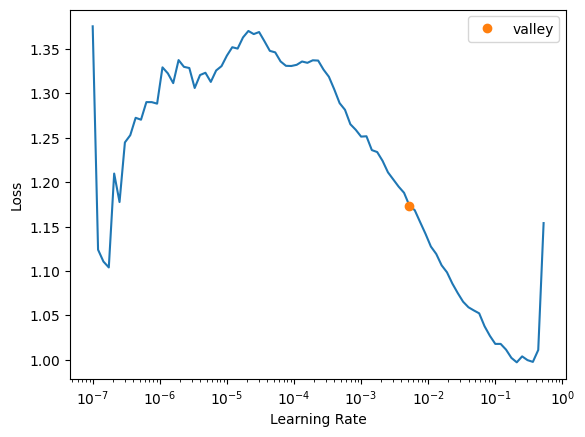

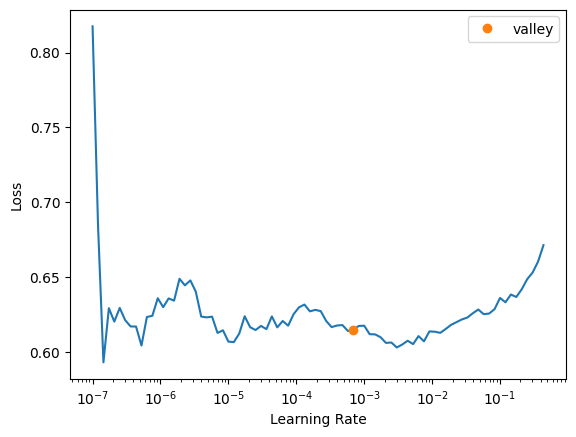

In [36]:
# Working ???
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start


In [37]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [40]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [35.09720230102539, 0.6725470423698425, 0.6658411026000977, 0.6658411026000977, 0.6658411026000977, 0.6658411026000977, 0.6658411026000977, 0.6554206013679504, 0.6554206013679504, 0.6554206013679504, 0.6554206013679504, 0.6554206013679504, 0.6554206013679504, 0.6554206013679504, 0.6554206013679504, 0.6554206013679504, 0.6554206013679504, 0.6496232151985168, 0.6423320770263672, 0.6423320770263672, 0.6423320770263672, 0.6423320770263672]
Validation error of SHADE-ILS-GD for 1 layers: [103.50697326660156, 1127.4820556640625, 1095.106201171875, 1095.106201171875, 1095.106201171875, 1095.106201171875, 1095.106201171875, 314.2409362792969, 314.2409362792969, 314.2409362792969, 314.2409362792969, 314.2409362792969, 314.2409362792969, 314.2409362792969, 314.2409362792969, 314.2409362792969, 314.2409362792969, 733.8253173828125, 748.0606079101562, 748.0606079101562, 748.0606079101562, 748.0606079101562]
Difference: [  68.40977097 1126.80950862 1094.4

### Save or load

In [39]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [30]:
#Load the trained mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

### Comparison between MH

In [31]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [32]:
#Calculate r2sq
r2sq = {}
#f1score = {}
for mh in algs:
  #f1score[mh] = {}
  r2sq[mh] = {}
  for layer in n_layers:
    #1score[mh][layer] = []
    r2sq[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      r2sq[mh][layer].append(utilsTFG.adjusted_r2_score(preds, targs))


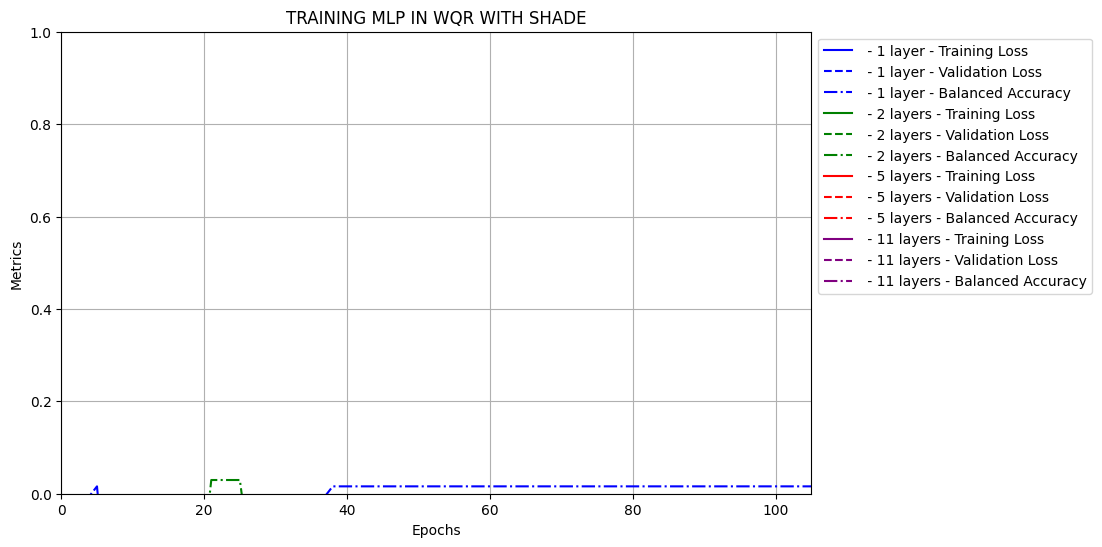

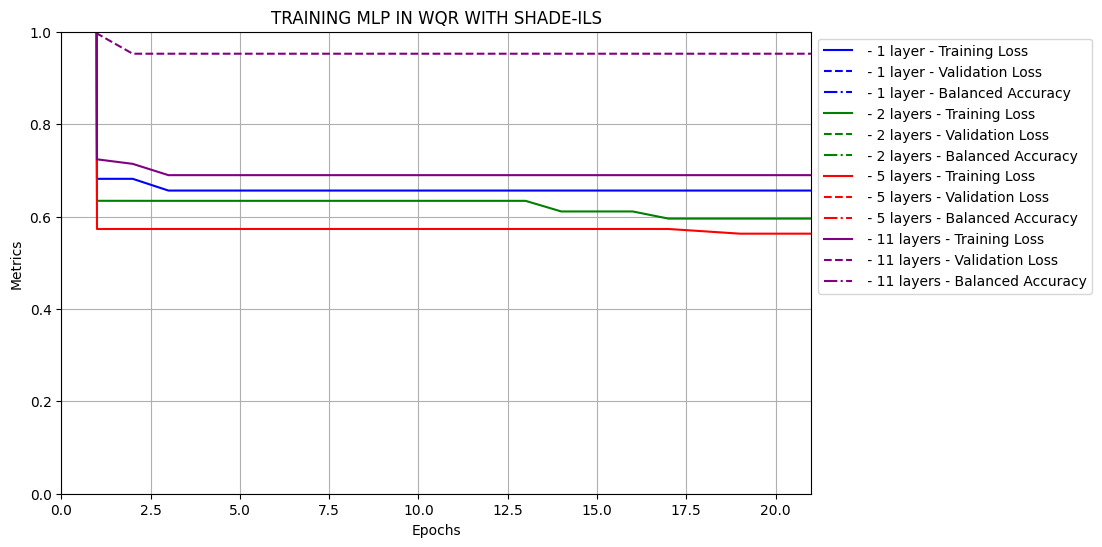

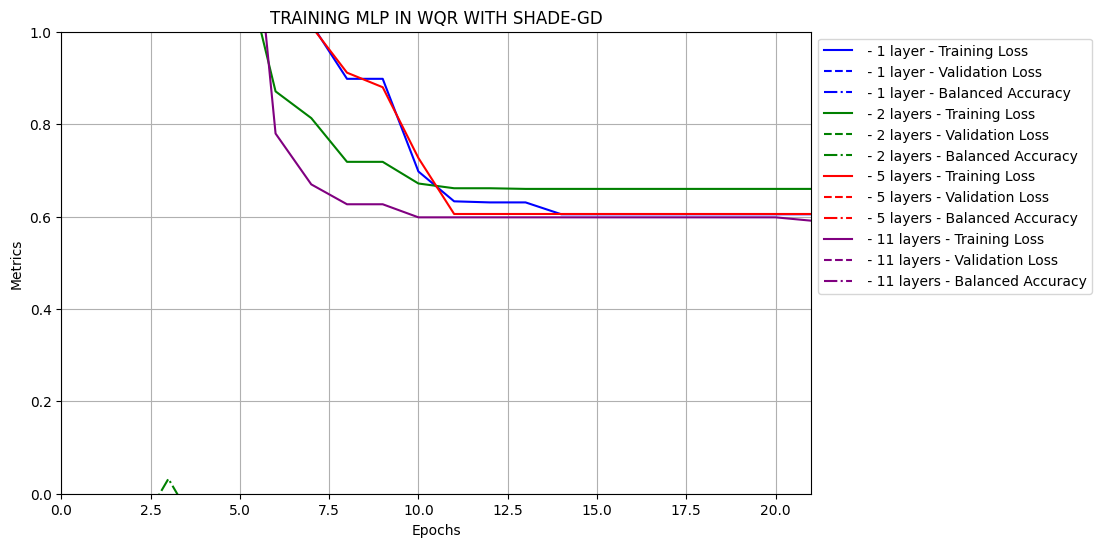

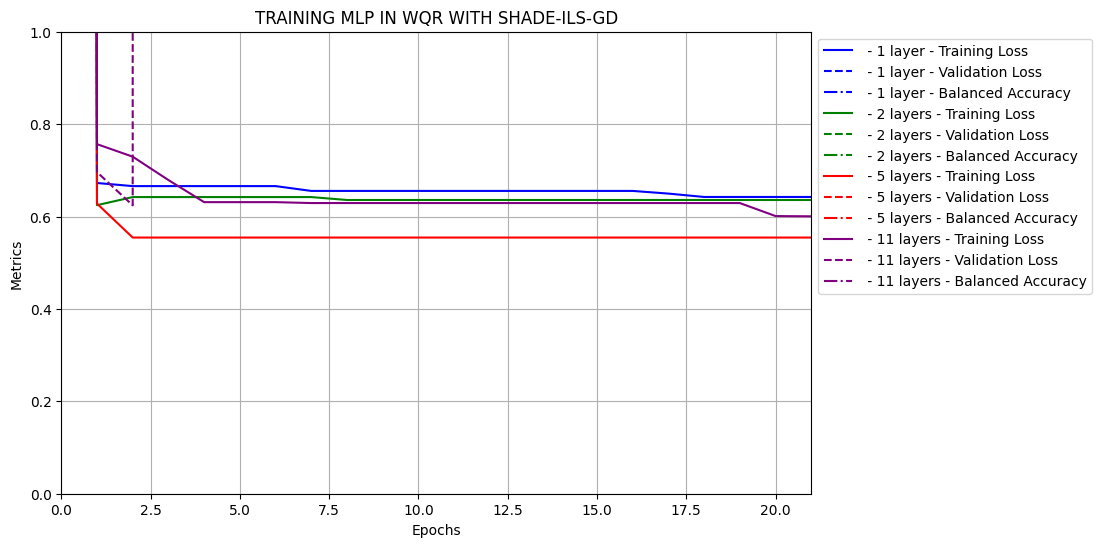

In [38]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], r2sq[alg],  layers = n_layers, names=names, title=f'TRAINING MLP IN {plot_dataset} WITH {alg}')

In [ ]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
r2 = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  r2[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    r2[layer][alg] = r2sq[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], r2[layer], layers = names, names=names, title=f'TRAINING MLP IN {plot_dataset} WITH {layer} LAYERS')

### Generalization

In [45]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.adjusted_r2_score(preds, targs)

    #Calculate F1-Score
    #f1 = utilsTFG.f1_score_func(preds, targs)

    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test', task='reg')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, R2 Square: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 62.588863372802734, R2 Square: -0.10525753712462427


Optimizer: SHADE, Layers: 2, Loss: 26.110950469970703, R2 Square: -0.3104483666305593


Optimizer: SHADE, Layers: 5, Loss: 26.501928329467773, R2 Square: -24.10117461739754


Optimizer: SHADE, Layers: 11, Loss: 32.675655364990234, R2 Square: -23543.782521034474


Optimizer: SHADE-ILS, Layers: 1, Loss: 97.4280014038086, R2 Square: -0.021472525791063735


Optimizer: SHADE-ILS, Layers: 2, Loss: 126.02955627441406, R2 Square: -0.04452213537888983


Optimizer: SHADE-ILS, Layers: 5, Loss: 13.1353178024292, R2 Square: -0.5371716671082429


Optimizer: SHADE-ILS, Layers: 11, Loss: 0.9578546285629272, R2 Square: -4.579735131715756


Optimizer: SHADE-GD, Layers: 1, Loss: 97.4280014038086, R2 Square: -0.021472525791063735


Optimizer: SHADE-GD, Layers: 2, Loss: 45.53528594970703, R2 Square: 0.035140356423725594


Optimizer: SHADE-GD, Layers: 5, Loss: 40.19126892089844, R2 Square: -83.72724015623764


Optimizer: SHADE-GD, Layers: 11, Loss: 32.725040435791016, R2 Square: -28415.968730452594


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 97.4280014038086, R2 Square: -0.021472525791063735


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 126.02955627441406, R2 Square: -0.04452213537888983


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 11.829377174377441, R2 Square: -0.5452185676082586


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 0.6795660257339478, R2 Square: -1.7277709783282114


## Time comparison

In [46]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by SHADE training with 1 layers: 714.9010 seconds
Time consumed by SHADE training with 2 layers: 763.5227 seconds
Time consumed by SHADE training with 5 layers: 956.5047 seconds
Time consumed by SHADE training with 11 layers: 1925.9403 seconds
Time consumed by SHADE-ILS training with 1 layers: 739.3230 seconds
Time consumed by SHADE-ILS training with 2 layers: 810.6869 seconds
Time consumed by SHADE-ILS training with 5 layers: 1019.5268 seconds
Time consumed by SHADE-ILS training with 11 layers: 2131.8235 seconds
Time consumed by SHADE-GD training with 1 layers: 727.6358 seconds
Time consumed by SHADE-GD training with 2 layers: 787.4650 seconds
Time consumed by SHADE-GD training with 5 layers: 979.3856 seconds
Time consumed by SHADE-GD training with 11 layers: 1955.8328 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 760.9398 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 832.6458 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 1